In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/Users/iman/Documents/Iman/Portfolio/Iman Mousavi Portfolio/posts/Doctors Segmentation':
  os.chdir(r'/Users/iman/Documents/Iman/Portfolio/Iman Mousavi Portfolio/posts/Doctors Segmentation')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/var/folders/0s/5nvdy8kx70q7tvgqp_3xvyx00000gn/T/ipykernel_1768/3346501274.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/importlib/_bootstrap.py": 1648071155.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/importlib/_bootstrap_external.py": 1648071155.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/codecs.py": 1648071154.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/encodings/aliases.py": 1648071154.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/encodings/__init__.py": 1648071154.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/encodings/utf_8.py": 1648071155.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py": 1648071154.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/io.py": 1648071154.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/stat.py": 1648071154.0, "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/_collections_abc.py": 1648071154.0,

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from IPython.display import display, Markdown
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import KernelPCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.cluster.vq import kmeans, vq

In [3]:
doctors = pd.read_csv('doctors.csv')
orders = pd.read_csv('orders.csv')
complaints = pd.read_csv('complaints.csv')
instruction = pd.read_csv('instructions.csv')

In [4]:
display(doctors.head())
display(doctors.info())

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,Purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,--,0.00,34.0
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,--,0.48,29.0
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DoctorID        437 non-null    object 
 1   Region          437 non-null    object 
 2   Category        437 non-null    object 
 3   Rank            435 non-null    object 
 4   Incidence rate  437 non-null    float64
 5   R rate          437 non-null    float64
 6   Satisfaction    437 non-null    object 
 7   Experience      437 non-null    float64
 8   Purchases       437 non-null    float64
dtypes: float64(4), object(5)
memory usage: 30.9+ KB


None

In [5]:
doctors.replace({'--':np.nan}, inplace=True)

In [6]:
print(doctors['Rank'].unique())
cat_type = CategoricalDtype(categories=['Silver', 'Silver Plus',
                                         'Gold', 'Gold Plus', 'Platinum',
                                         'Platinum Plus', 'Titanium',
                                         'Titanium Plus', 'Ambassador'],
                                         ordered=True)
doctors['Rank'] = doctors['Rank'].astype(cat_type)

['Ambassador' 'Platinum Plus' 'Titanium' 'Silver Plus' 'Gold' 'Platinum'
 'Gold Plus' 'Silver' nan 'Titanium Plus']


In [7]:
doctors['Category'] = doctors['Category'].astype('category')
doctors['Region'] = doctors['Region'].astype('category')

In [8]:
doctors['Satisfaction'] = doctors['Satisfaction'].astype('float64')

In [9]:
doctors.rename({'Purchases':'last_purchases'}, inplace = True, axis = 1)

In [10]:
display(doctors.head())
display(doctors.info())

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,last_purchases
0,AHDCBA,4 15,Specialist,Ambassador,49.0,0.90,53.85,1.20,49.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.0,0.00,100.00,0.00,38.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.0,1.53,NaN,0.00,34.0
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.0,2.03,NaN,0.48,29.0
4,FJBEA,1 14 T4,Specialist,Ambassador,23.0,0.96,76.79,0.75,24.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DoctorID        437 non-null    object  
 1   Region          437 non-null    category
 2   Category        437 non-null    category
 3   Rank            435 non-null    category
 4   Incidence rate  437 non-null    float64 
 5   R rate          437 non-null    float64 
 6   Satisfaction    250 non-null    float64 
 7   Experience      437 non-null    float64 
 8   last_purchases  437 non-null    float64 
dtypes: category(3), float64(5), object(1)
memory usage: 23.8+ KB


None

In [11]:
display(orders.head())
display(orders.info())

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,False,False,False,False,False,True,True,False,Before
1,HBIEA,DGAJDAH,AIJIHGB,False,True,NaN,False,False,True,False,True,Before
2,GGCCD,DGBBDCB,AFEIHFB,False,False,False,False,False,False,False,False,NaN
3,EHHGF,DGCDCCF,AIBJJEE,False,False,False,True,False,False,True,False,Before
4,EHHGF,DGCFAGC,AEDBBDC,False,False,False,False,False,False,False,False,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DoctorID     257 non-null    object
 1   OrderID      257 non-null    object
 2   OrderNum     257 non-null    object
 3   Condition A  257 non-null    bool  
 4   Condition B  257 non-null    bool  
 5   Condition C  248 non-null    object
 6   Condition D  257 non-null    bool  
 7   Condition F  254 non-null    object
 8   Condition G  254 non-null    object
 9   Condition H  257 non-null    bool  
 10  Condition I  257 non-null    bool  
 11  Condition J  149 non-null    object
dtypes: bool(5), object(7)
memory usage: 15.4+ KB


None

In [12]:
display(orders['Condition C'].head())
display(orders['Condition C'].unique())

0    False
1      NaN
2    False
3    False
4    False
Name: Condition C, dtype: object

array([False, nan, True], dtype=object)

In [13]:
orders.replace({True:1, False:0}, inplace=True)
orders.replace({'Before':0, 'After':1}, inplace=True)

orders['Condition C'] = orders['Condition C'].astype('Int16')
orders['Condition F'] = orders['Condition F'].astype('Int16')
orders['Condition G'] = orders['Condition G'].astype('Int16')
orders['Condition J'] = orders['Condition J'].astype('Int16')

In [14]:
display(orders.head())
display(orders.info())

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
0,ABJEAI,DGEJFDC,AIBEHCJ,0,0,0,0,0,1,1,0,0
1,HBIEA,DGAJDAH,AIJIHGB,0,1,<NA>,0,0,1,0,1,0
2,GGCCD,DGBBDCB,AFEIHFB,0,0,0,0,0,0,0,0,<NA>
3,EHHGF,DGCDCCF,AIBJJEE,0,0,0,1,0,0,1,0,0
4,EHHGF,DGCFAGC,AEDBBDC,0,0,0,0,0,0,0,0,<NA>


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DoctorID     257 non-null    object
 1   OrderID      257 non-null    object
 2   OrderNum     257 non-null    object
 3   Condition A  257 non-null    int64 
 4   Condition B  257 non-null    int64 
 5   Condition C  248 non-null    Int16 
 6   Condition D  257 non-null    int64 
 7   Condition F  254 non-null    Int16 
 8   Condition G  254 non-null    Int16 
 9   Condition H  257 non-null    int64 
 10  Condition I  257 non-null    int64 
 11  Condition J  149 non-null    Int16 
dtypes: Int16(4), int64(5), object(3)
memory usage: 19.2+ KB


None

In [15]:
doctorid_orders = len(orders['DoctorID'].unique())
orderid_orders = len(orders['OrderID'].unique())

display(Markdown(f'There are {orders.shape[0]} records in orders data set. Number of unique DoctorID in order data set is {doctorid_orders} and the number of OrderID in that data set is {orderid_orders}. In other words, there are a few order cases that are duplicated and should be treated approporiatly.'))

There are 257 records in orders data set. Number of unique DoctorID in order data set is 76 and the number of OrderID in that data set is 249. In other words, there are a few order cases that are duplicated and should be treated approporiatly.

In [16]:
display(orders[orders.duplicated(subset = 'OrderID', keep = False)])

,DoctorID,OrderID,OrderNum,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J
9,BCFJAB,DEIIFJB,AHFEGEI,0,0,0,0,0,0,1,0,0
10,BCFJAB,DEIIFJB,AHFEGEI,0,0,0,1,0,0,1,0,0
52,FJAJH,DGDIDFI,AIBECHD,0,0,0,0,0,1,1,0,0
53,FJAJH,DGDIDFI,AIBECHD,0,0,0,1,0,1,1,0,0
65,IFDIB,DGJECBF,AIJGEBJ,0,0,0,0,0,1,0,0,0
66,IFDIB,DGJECBF,AIJGEBJ,0,0,0,0,0,1,1,0,0
80,BCGFDD,DGIJDHB,AEFEHBC,0,0,0,0,0,0,0,0,<NA>
81,BCGFDD,DGIJDHB,AEFEHBC,0,0,1,1,0,0,0,0,<NA>
146,FAGIE,DGAGDHB,AFAGEGI,0,0,0,0,0,0,0,0,<NA>
147,FAGIE,DGAGDHB,AFAGEGI,0,0,0,1,0,0,0,0,<NA>


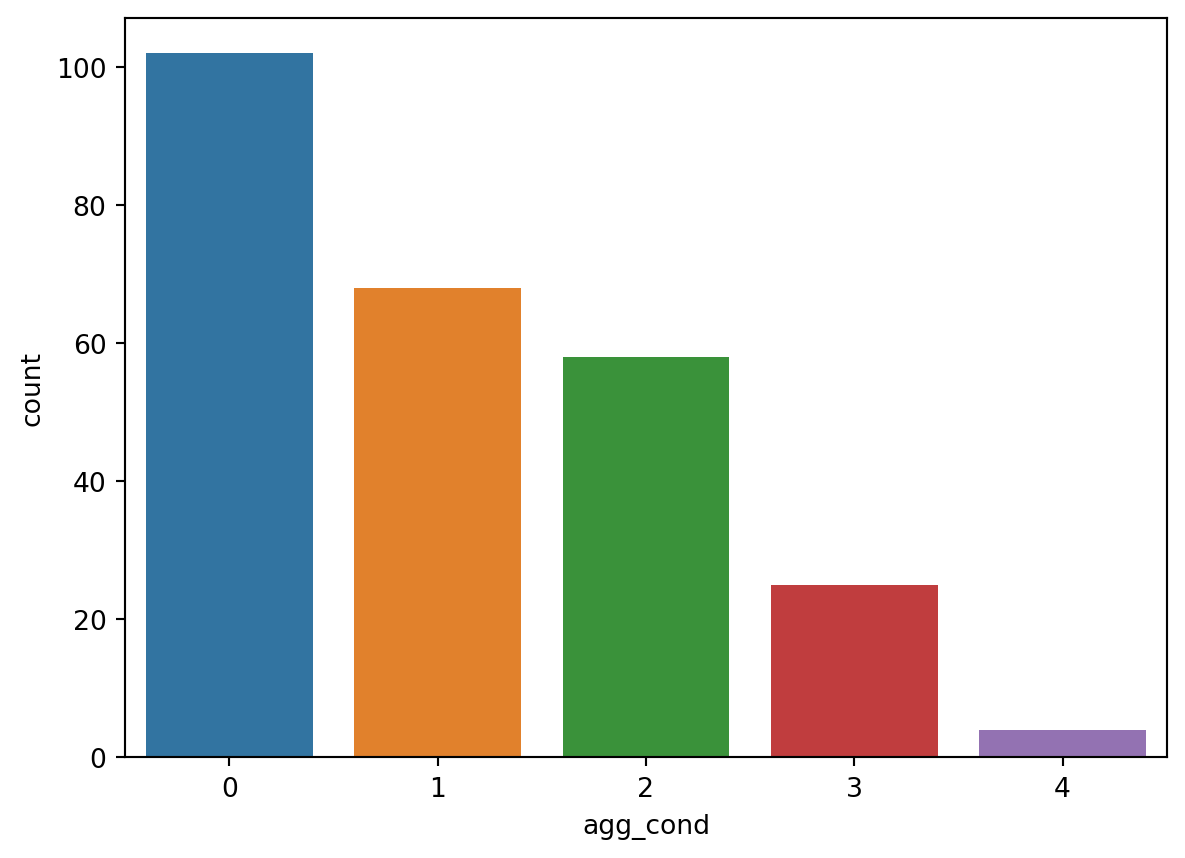

<Figure size 672x480 with 0 Axes>

In [17]:
agg_conditions = orders.loc[:, 'Condition A':'Condition J']\
.sum(axis = 1).astype('category')

agg_conditions_df = pd.DataFrame({'agg_cond':agg_conditions})

sns.countplot(x = 'agg_cond', data = agg_conditions_df)
plt.show()
plt.clf()

In [18]:
orders.drop_duplicates(subset = ['OrderID'], inplace = True)

In [19]:
conditions = orders.filter(like = 'Condition')
agg_orders = orders.groupby('DoctorID')[conditions.columns].sum()\
.reset_index()

agg_orders['total_settings'] = agg_orders.loc[:,'Condition A':'Condition J'].sum(axis = 1)

agg_orders['total_orders'] = orders.groupby('DoctorID')['OrderID'].size().values

display(agg_orders)

,DoctorID,Condition A,Condition B,Condition C,Condition D,Condition F,Condition G,Condition H,Condition I,Condition J,total_settings,total_orders
0,AAAEAH,3,2,0,0,0,1,3,2,0,11,18
1,AABDHC,0,0,0,0,0,0,1,0,0,1,1
2,AABGAB,0,0,1,0,0,1,3,0,0,5,4
3,AADDIG,0,0,0,0,0,0,0,0,0,0,2
4,AAEIEG,0,0,1,1,0,1,1,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
71,HCBFF,0,0,0,0,0,0,0,1,0,1,1
72,HCIGF,1,1,0,0,0,0,0,0,0,2,2
73,HJDFA,0,1,0,0,0,0,1,0,0,2,2
74,IAEBD,0,0,0,0,0,0,0,0,0,0,1


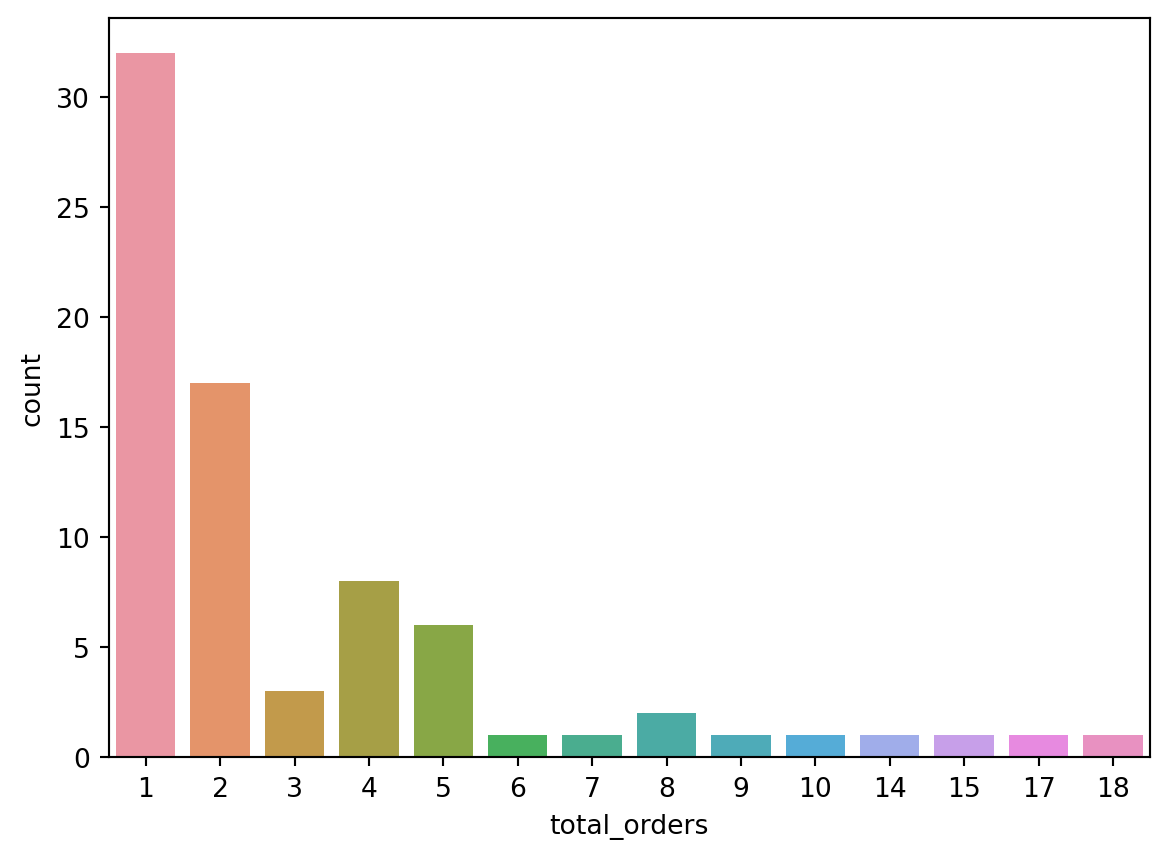

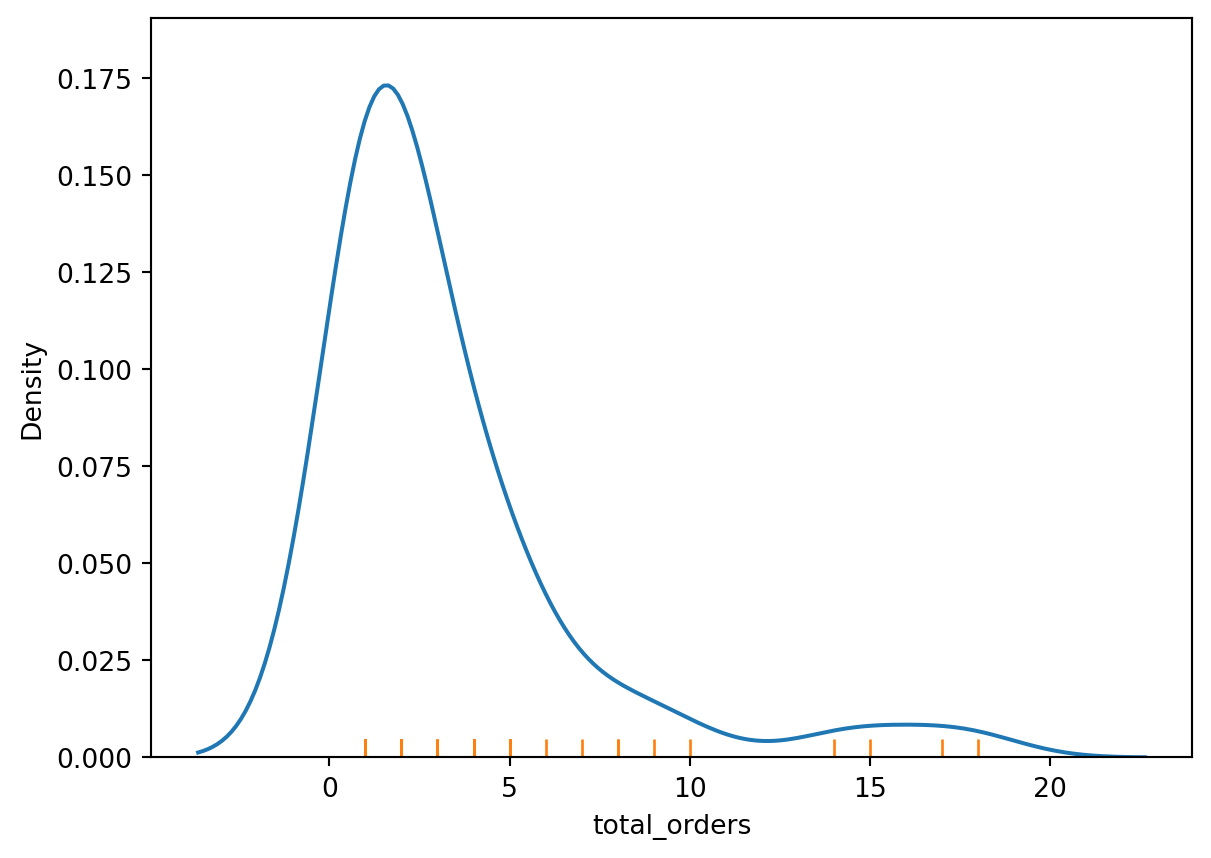

<Figure size 672x480 with 0 Axes>

In [20]:
sns.countplot(x = 'total_orders', data = agg_orders)
plt.show()
plt.clf()

sns.kdeplot(x = 'total_orders', data = agg_orders)
sns.rugplot(x = 'total_orders', data = agg_orders)
plt.show()
plt.clf()

In [21]:
display(complaints.head())
display(complaints.info())

,DoctorID,Complaint Type,Qty
0,EHAHI,Correct,10
1,EHDGF,Correct,2
2,EHDGF,Unknown,3
3,EHDIJ,Correct,8
4,EHDIJ,Incorrect,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DoctorID        435 non-null    object
 1   Complaint Type  433 non-null    object
 2   Qty             435 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ KB


None

In [22]:
display(Markdown(f'Complaints data set has {complaints["Complaint Type"].isnull().sum()} in Complaint Type column. We can drop both safely.'))

complaints.dropna(inplace = True)

Complaints data set has 2 in Complaint Type column. We can drop both safely.

In [23]:
num_uniq_complaints = len(complaints['DoctorID'].unique())
display(Markdown(f'Number of unique DoctorIDs in complaints data is {num_uniq_complaints} and the number of cases in this data set is {complaints.shape[0]}. Therefore, some doctors have had more than one complaints.'))

Number of unique DoctorIDs in complaints data is 284 and the number of cases in this data set is 433. Therefore, some doctors have had more than one complaints.

In [24]:
complaints_wider = complaints.pivot(columns = ['Complaint Type'], index = ['DoctorID'],
values = ['Qty'])

complaints_wider.reset_index(inplace = True)

complaints_wider.fillna(0, inplace = True)

complaints_wider.columns = ['DoctorID'] + [name[1] for name in complaints_wider.columns[1:]]

float_columns = complaints_wider.select_dtypes(include=['float']).columns
complaints_wider[float_columns] = complaints_wider[float_columns].astype(int)

display(complaints_wider)

,DoctorID,Correct,Incorrect,R&R,Specific,Unknown
0,AAAEAH,1,0,0,0,0
1,AAAHCE,1,2,0,0,1
2,AABDHC,0,1,0,0,0
3,AABGAB,3,0,0,0,1
4,AACCGA,0,1,0,0,0
...,...,...,...,...,...,...
279,IEHGF,2,0,0,0,0
280,IEJIA,3,1,0,0,1
281,IFBHI,0,1,0,0,1
282,IFDIB,1,0,0,0,0


In [25]:
complaints_wider.drop('DoctorID', axis = 1).sum()

Correct      451
Incorrect    173
R&R            1
Specific       8
Unknown      145
dtype: int64

In [26]:
complaints_wider['total_complaints'] = complaints_wider.iloc[:,1:6].sum(axis = 1)

In [27]:
display(instruction.head())
display(instruction.info())

,DoctorID,Instructions
0,ADIFBD,Yes
1,ABHBED,No
2,FJFEG,Yes
3,AEBDAB,No
4,AJCBFE,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DoctorID      77 non-null     object
 1   Instructions  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


None

In [28]:
num_uniq_instruction = len(instruction['DoctorID'].unique())
display(Markdown(f'Number of unique DoctorIDs in instruction data is {num_uniq_instruction} and the number of cases in this data set is {instruction.shape[0]}. In other words, there are no duplicated instructions.'))

Number of unique DoctorIDs in instruction data is 77 and the number of cases in this data set is 77. In other words, there are no duplicated instructions.

In [29]:
instruction.replace({'Yes':1, 'No':0}, inplace = True)

In [30]:
merged_data = doctors.merge(agg_orders, on = 'DoctorID', how = 'left')\
.merge(complaints_wider, on = 'DoctorID', how = 'left')\
.merge(instruction, on = 'DoctorID', how = 'left')

missing_merged = merged_data.loc[:,'Condition A':].columns
merged_data[missing_merged] = merged_data[missing_merged].fillna(0)

int_columns = merged_data.loc[:,'Condition A':'Instructions'].columns
merged_data[int_columns] = merged_data[int_columns].astype('float16')

display(merged_data)

,DoctorID,Region,Category,Rank,Incidence rate,R rate,Satisfaction,Experience,last_purchases,Condition A,...,Condition J,total_settings,total_orders,Correct,Incorrect,R&R,Specific,Unknown,total_complaints,Instructions
0,AHDCBA,4 15,Specialist,Ambassador,49.00,0.90,53.85,1.20,49.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,ABHAHF,1 8 T4,General Practitioner,Ambassador,37.00,0.00,100.00,0.00,38.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FDHFJ,1 9 T4,Specialist,Ambassador,33.00,1.53,NaN,0.00,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BJJHCA,1 10 T3,Specialist,Ambassador,28.00,2.03,NaN,0.48,29.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FJBEA,1 14 T4,Specialist,Ambassador,23.00,0.96,76.79,0.75,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,AIABDJ,1 10,Specialist,Ambassador,2.18,0.80,11.76,0.77,35.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0
433,BBAJCF,1 9 T4,Specialist,Ambassador,2.17,1.68,NaN,0.11,19.0,0.0,...,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
434,GGCFB,1 19 T4,Specialist,Ambassador,2.14,0.77,NaN,0.27,22.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
435,FDCEG,1 9,Specialist,Ambassador,2.13,0.84,100.00,0.32,25.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


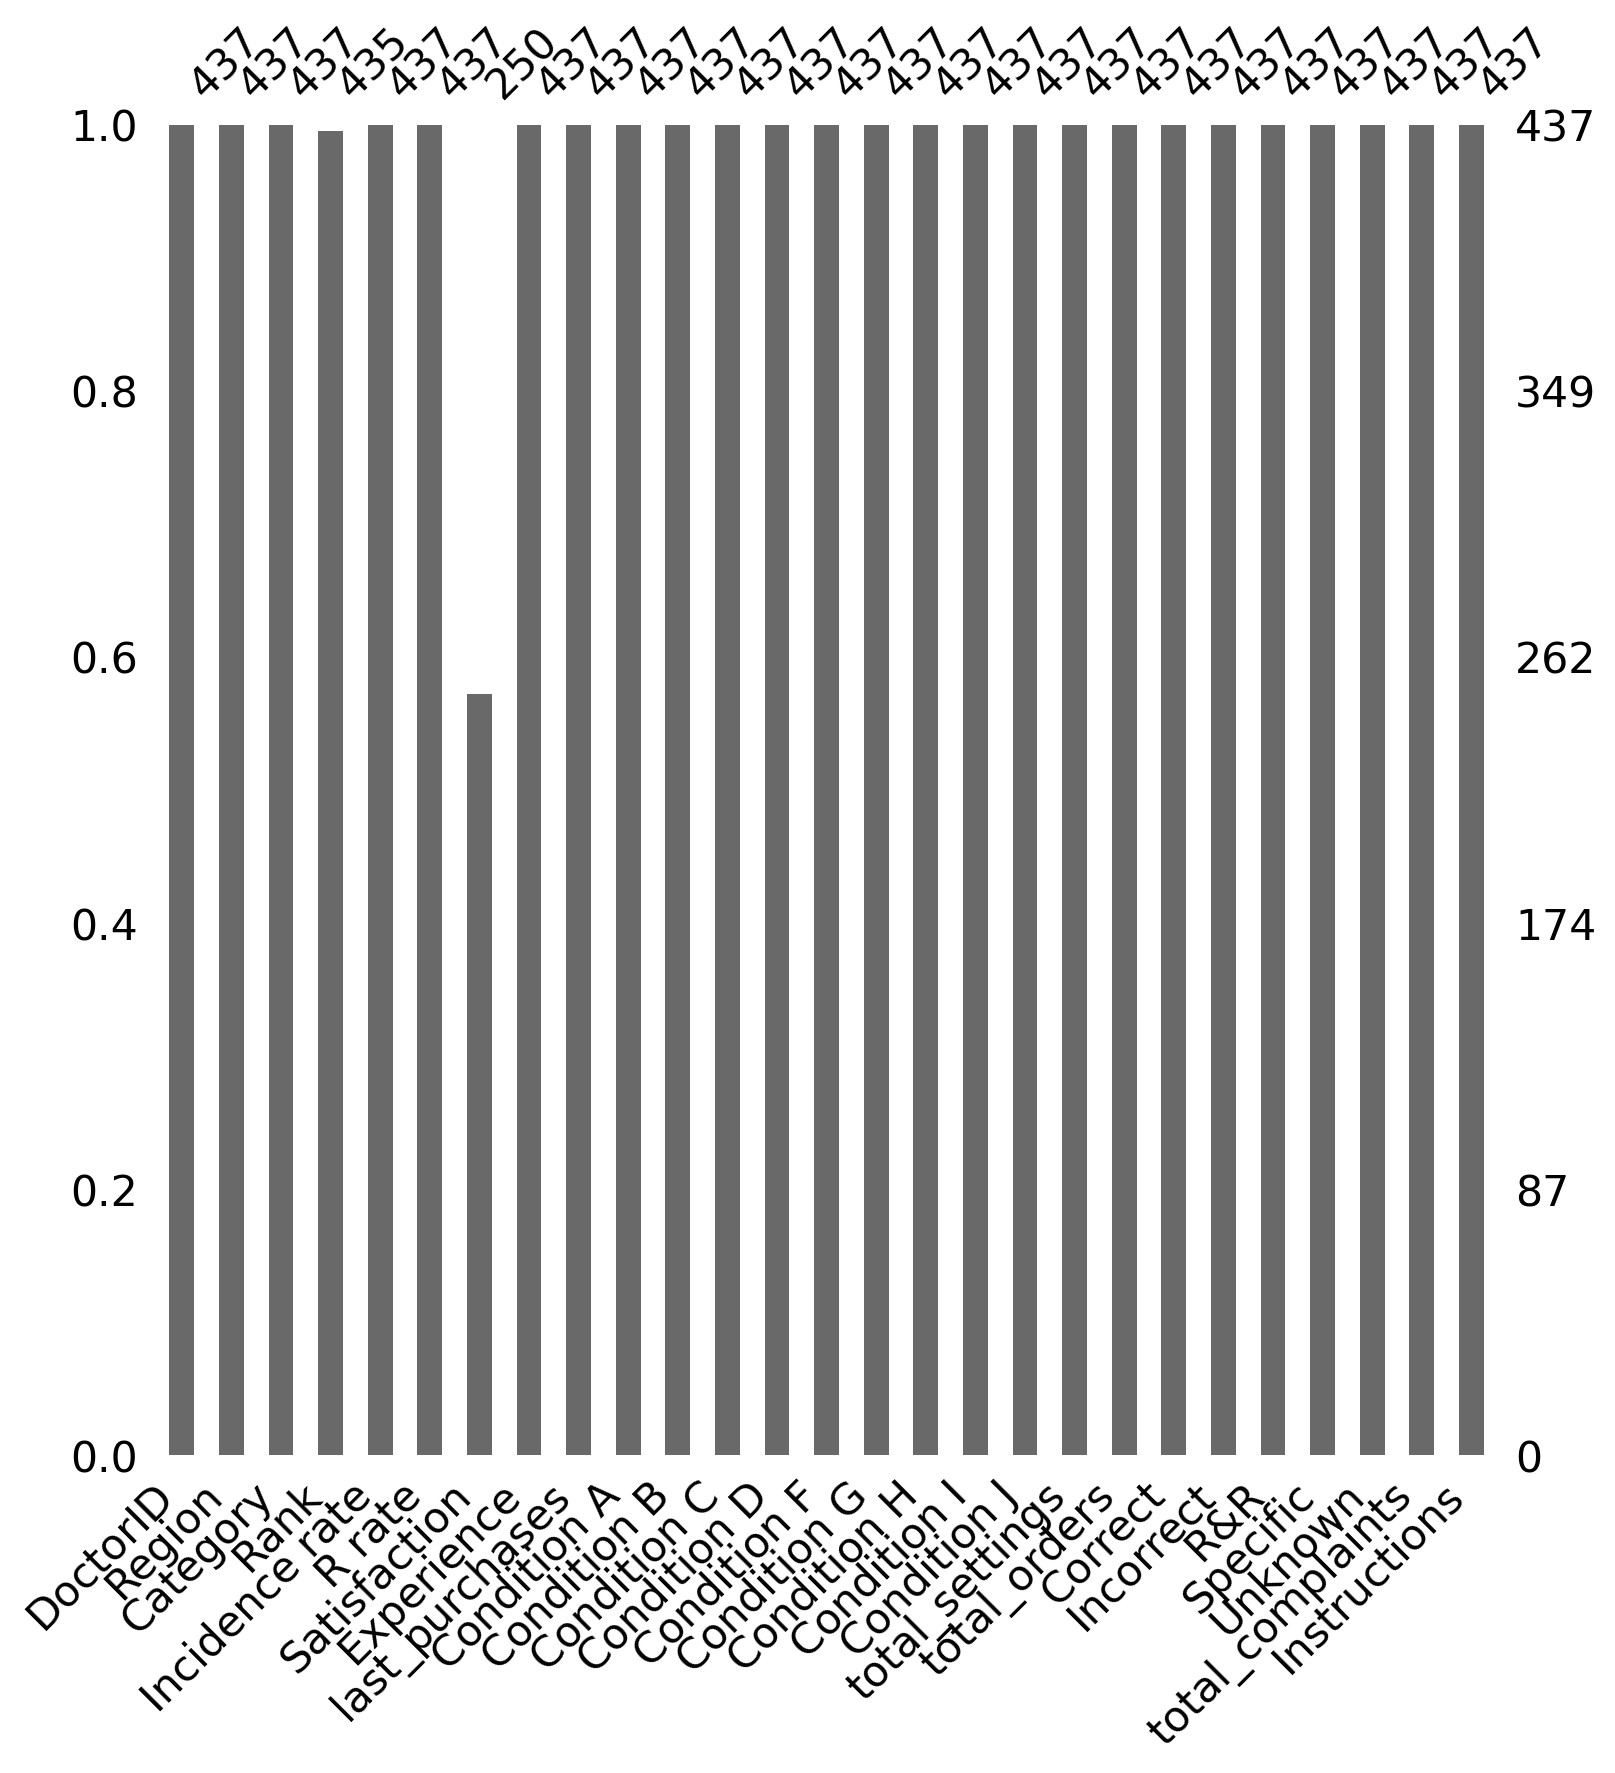

<Figure size 672x480 with 0 Axes>

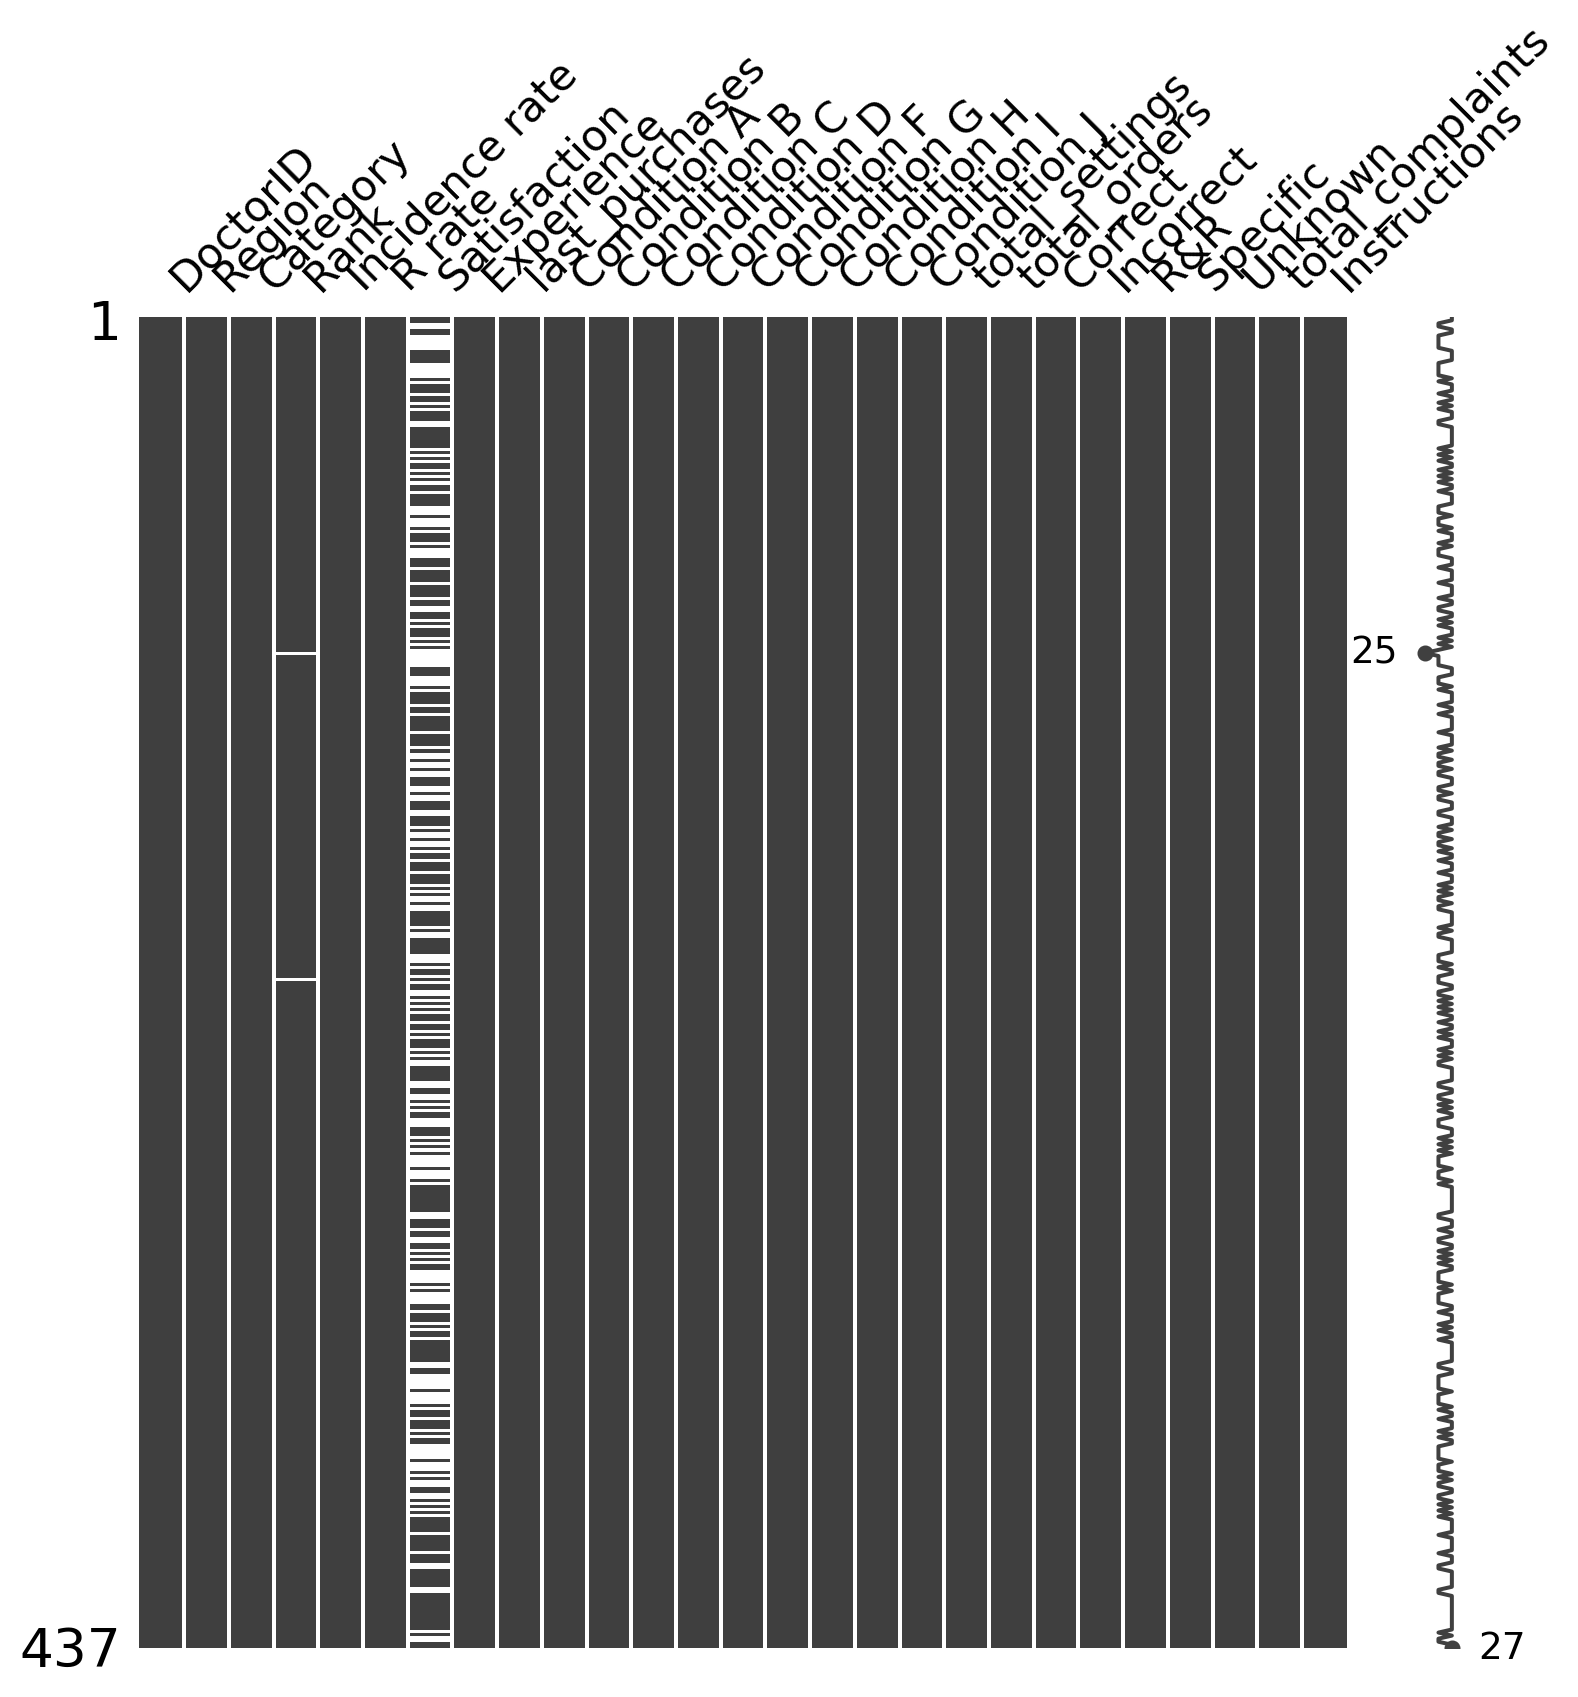

<Figure size 672x480 with 0 Axes>

In [31]:
msno.bar(merged_data, figsize = (9,9))
plt.show()
plt.clf()

msno.matrix(merged_data, figsize = (9,9))
plt.show()
plt.clf()

In [32]:
merged_data.dropna(subset = ['Rank'], inplace = True)

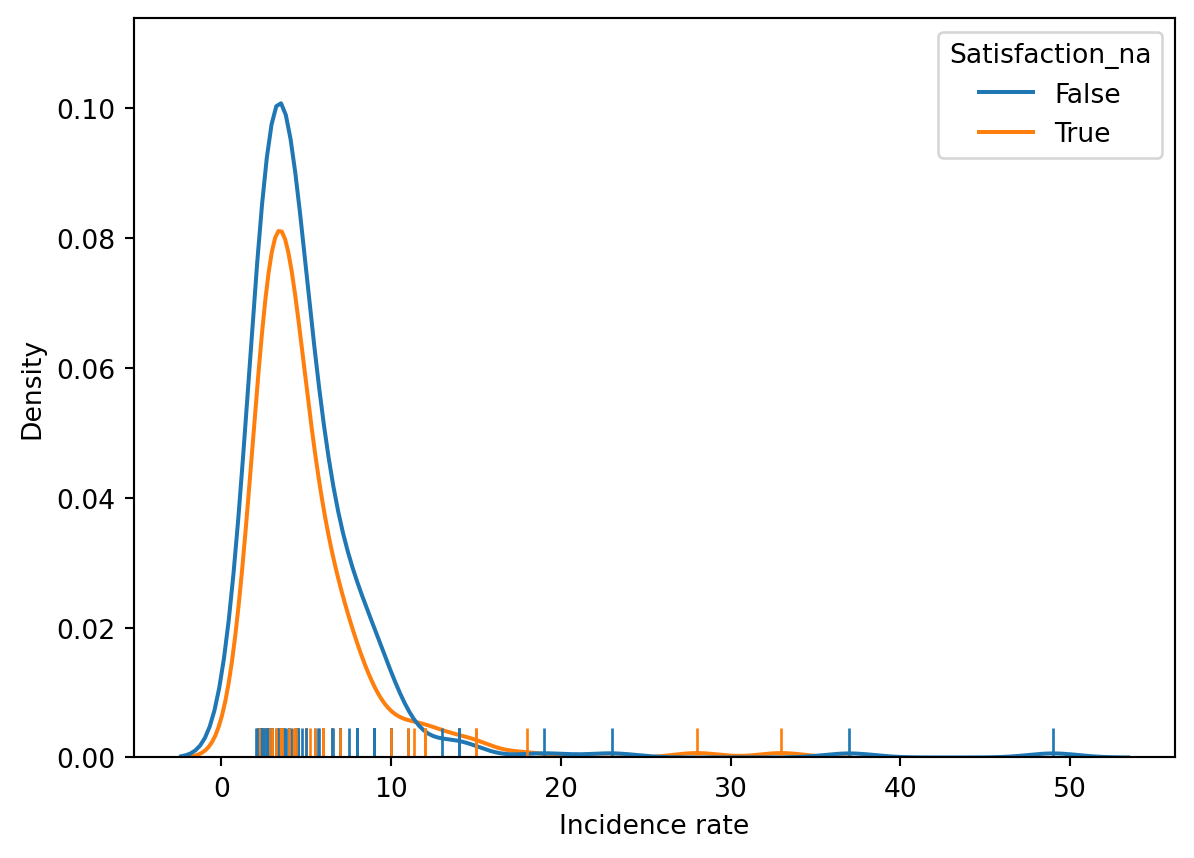

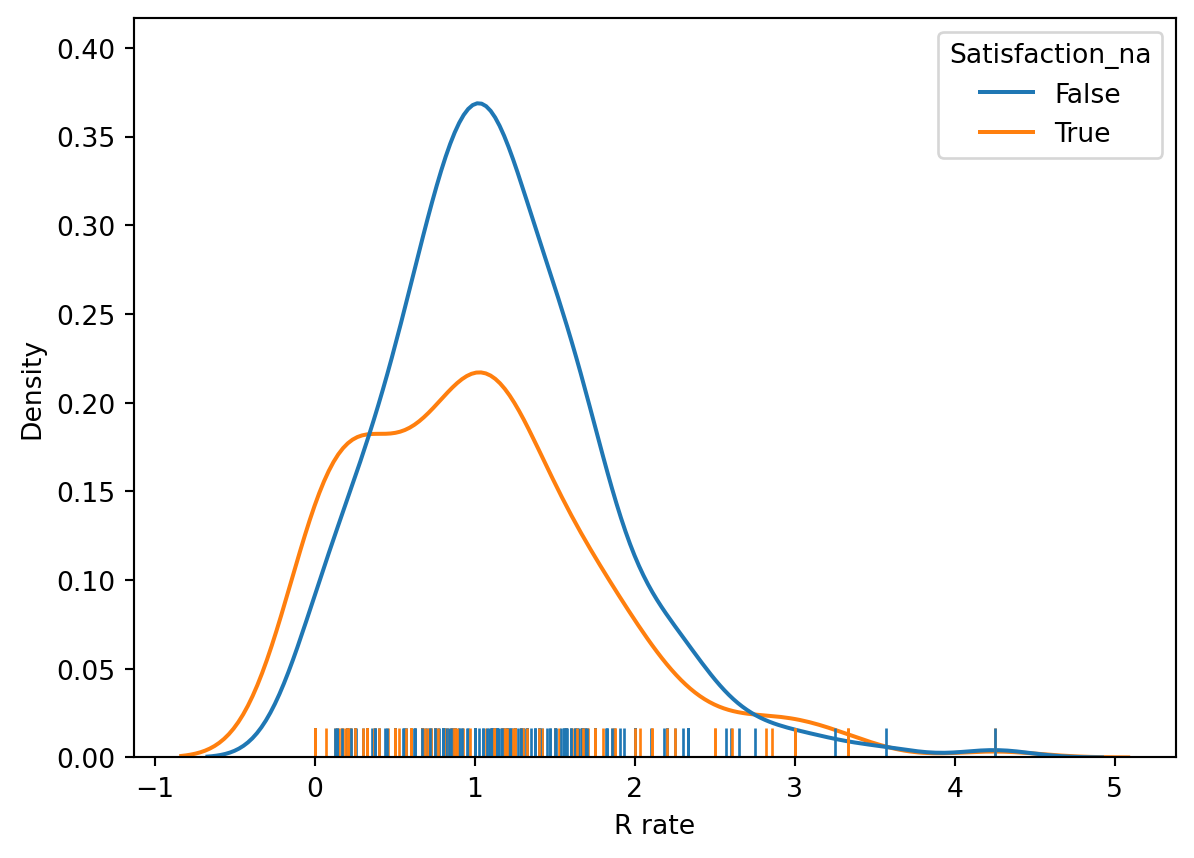

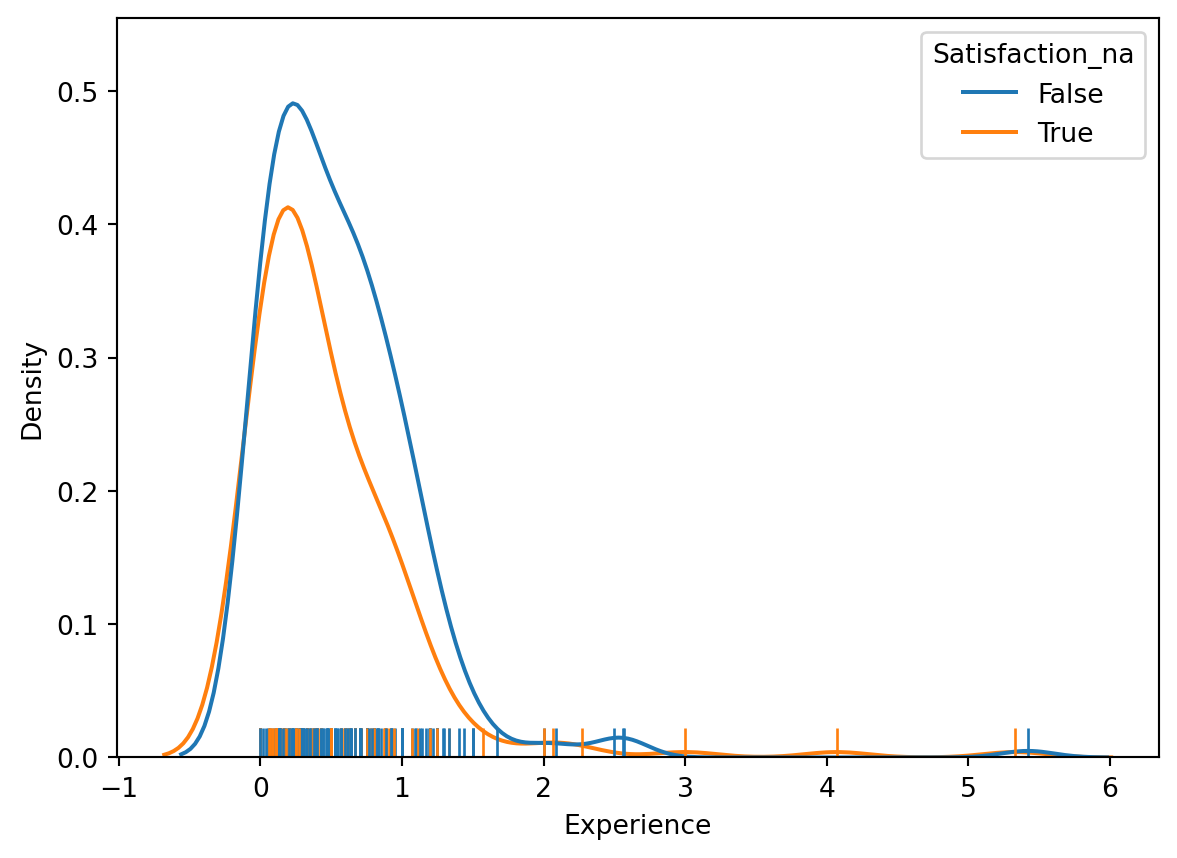

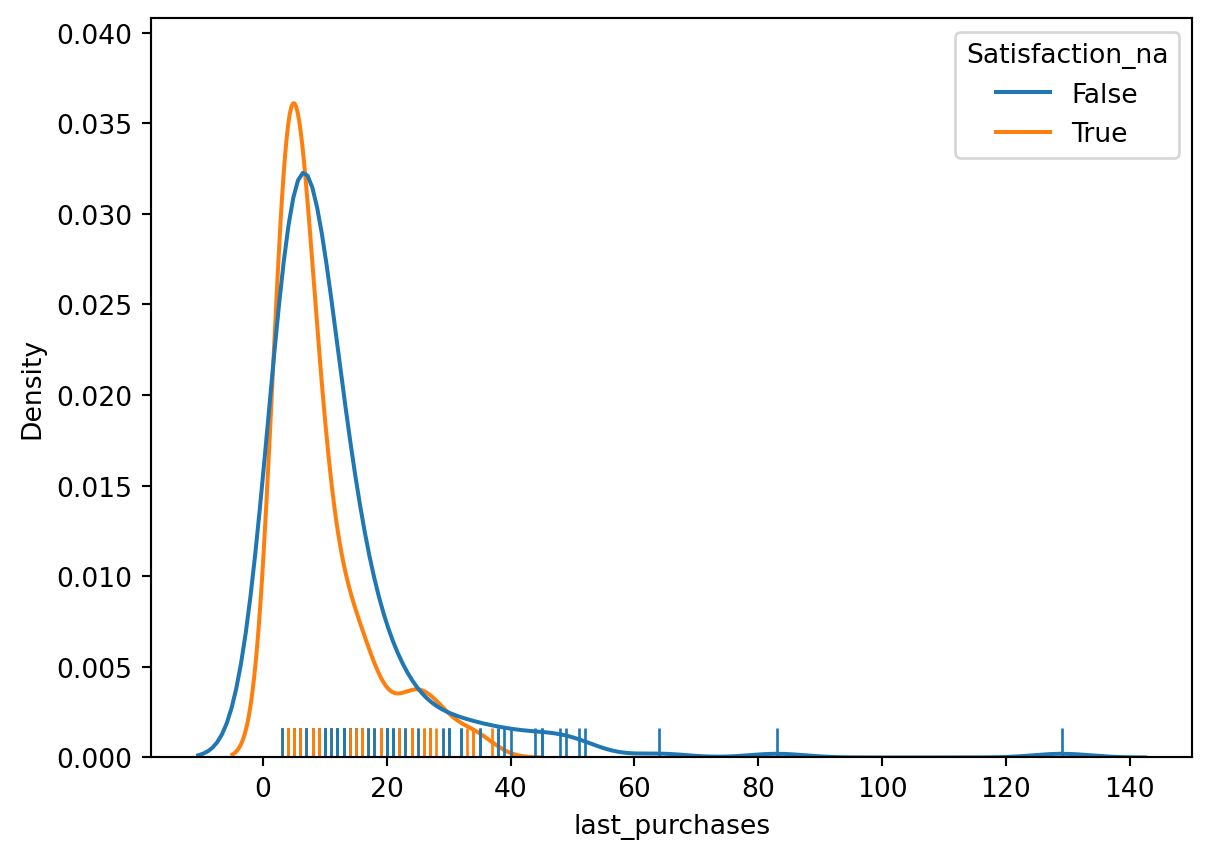

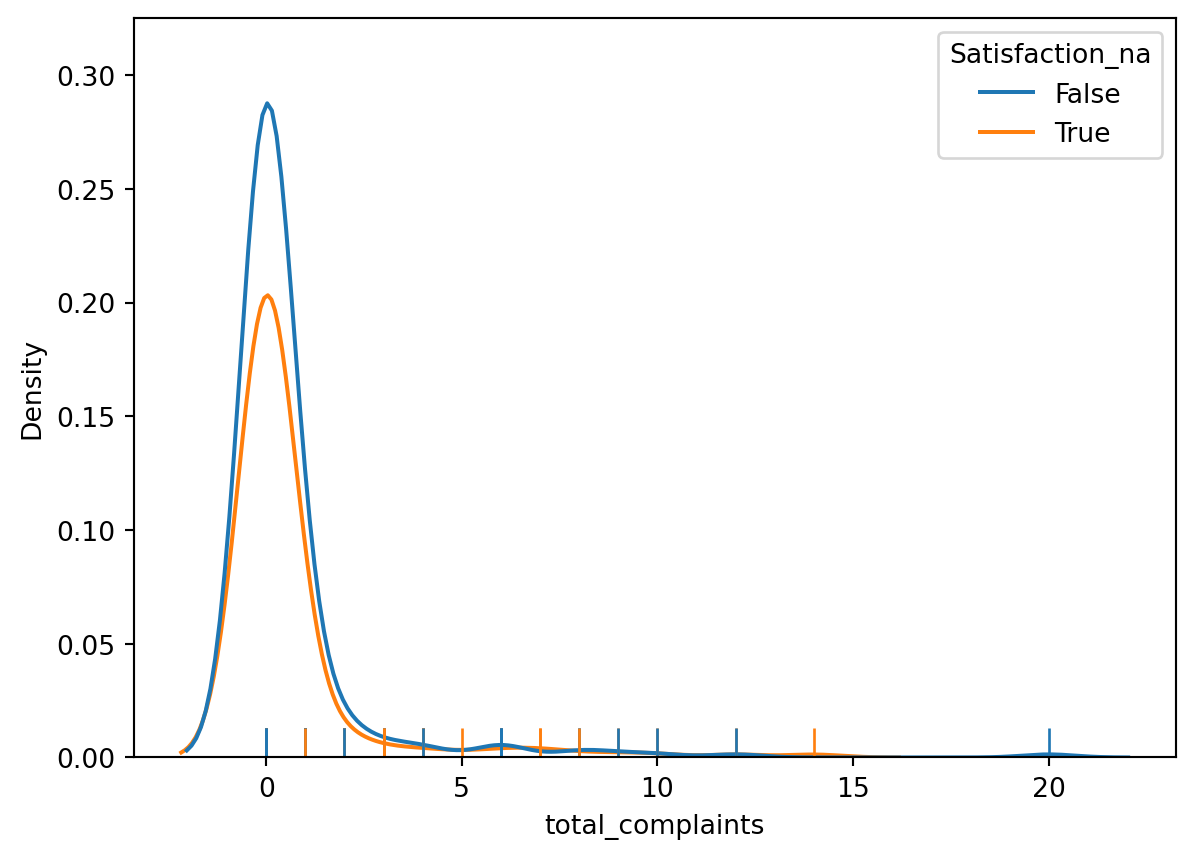

<Figure size 672x480 with 0 Axes>

In [33]:
merged_data['Satisfaction_na'] = merged_data['Satisfaction'].isnull()

merged_data.groupby('Category')['Satisfaction_na']\
.value_counts()

merged_data.groupby('Rank')['Satisfaction_na']\
.value_counts()

sns.kdeplot(x = 'Incidence rate', hue = 'Satisfaction_na', data = merged_data)
sns.rugplot(x = 'Incidence rate', hue = 'Satisfaction_na', data = merged_data, height = 0.04)
plt.show()
plt.clf()

sns.kdeplot(x = 'R rate', hue = 'Satisfaction_na', data = merged_data)
sns.rugplot(x = 'R rate', hue = 'Satisfaction_na', data = merged_data, height = 0.04)
plt.show()
plt.clf()

sns.kdeplot(x = 'Experience', hue = 'Satisfaction_na', data = merged_data)
sns.rugplot(x = 'Experience', hue = 'Satisfaction_na', data = merged_data, height = 0.04)
plt.show()
plt.clf()

sns.kdeplot(x = 'last_purchases', hue = 'Satisfaction_na', data = merged_data)
sns.rugplot(x = 'last_purchases', hue = 'Satisfaction_na', data = merged_data, height = 0.04)
plt.show()
plt.clf()

sns.kdeplot(x = 'total_complaints', hue = 'Satisfaction_na', data = merged_data)
sns.rugplot(x = 'total_complaints', hue = 'Satisfaction_na', data = merged_data, height = 0.04)
plt.show()
plt.clf()

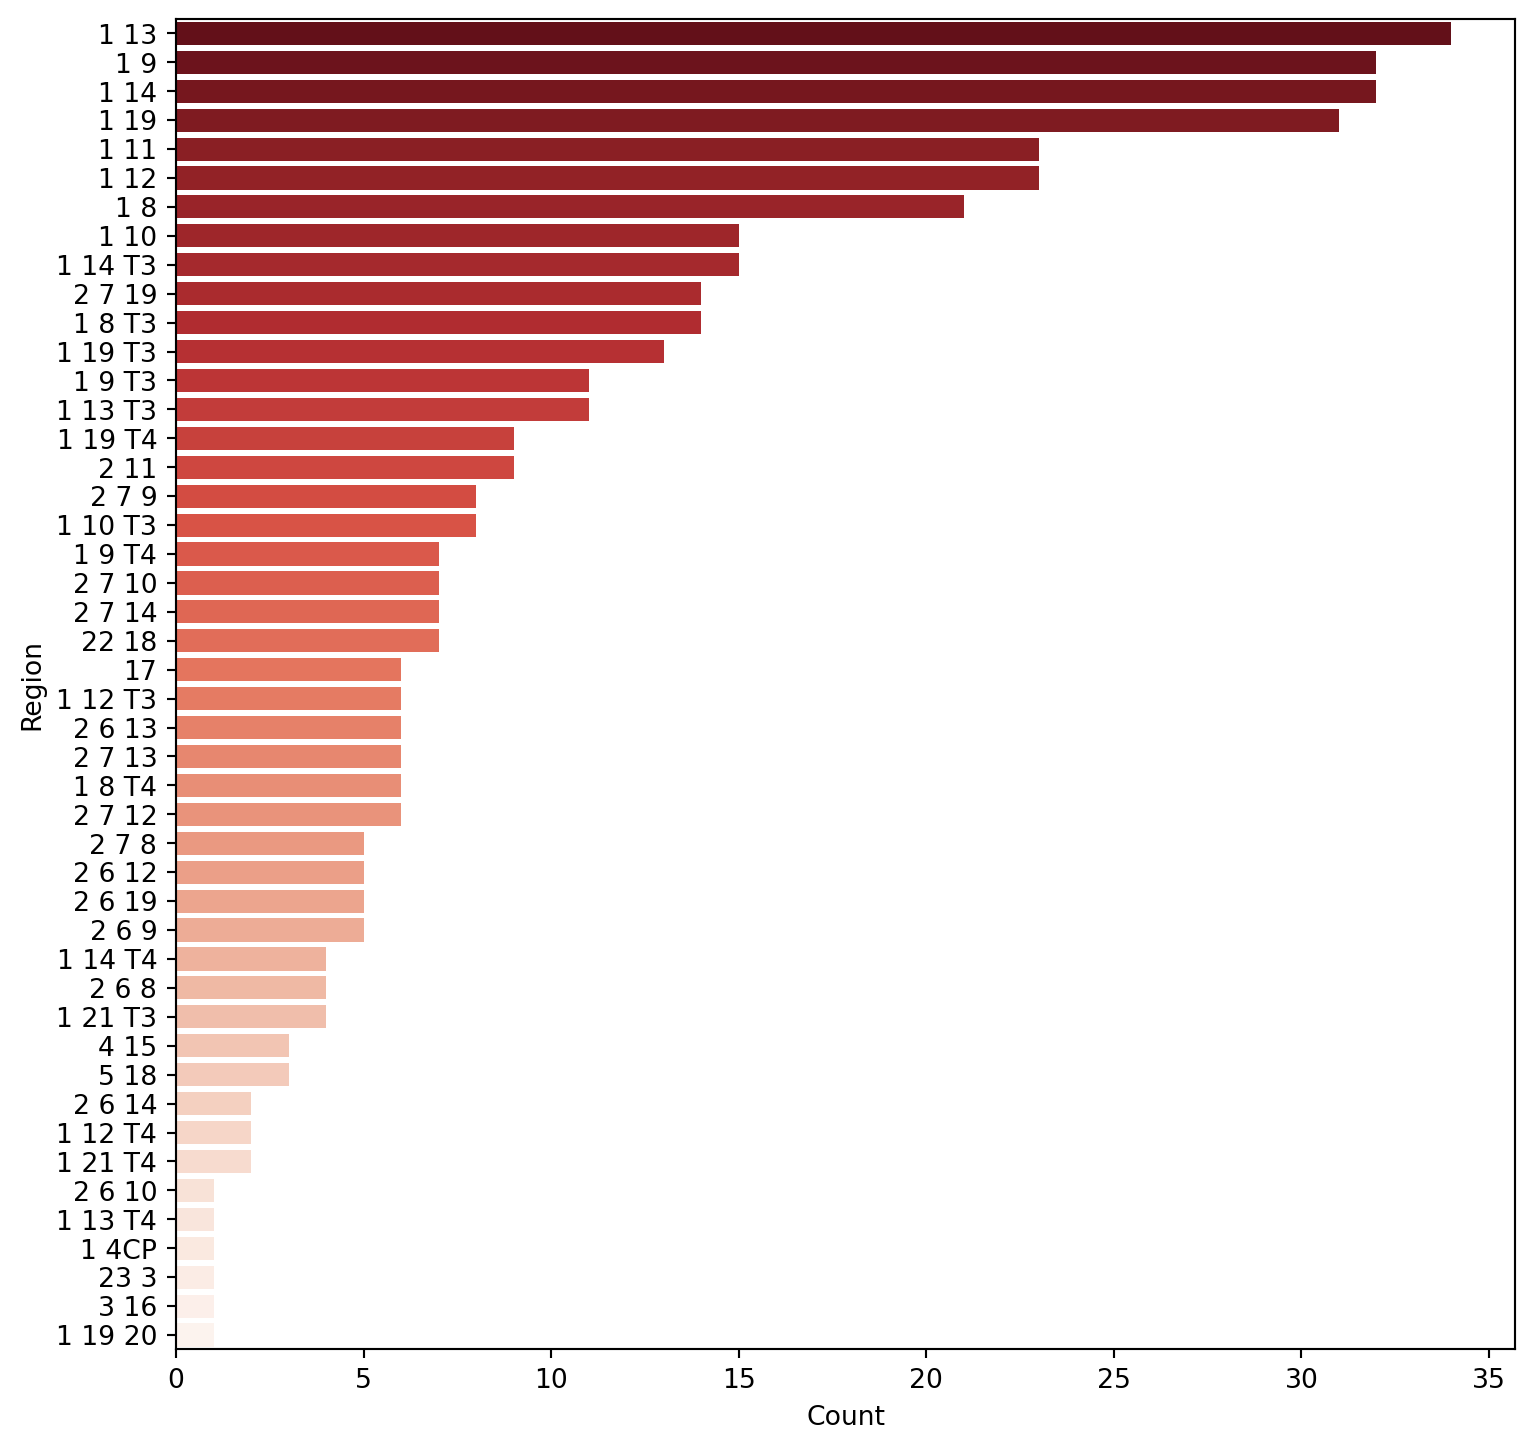

<Figure size 672x480 with 0 Axes>

In [34]:
agg_doctors = doctors.groupby('Region').size().to_frame().reset_index()
agg_doctors.columns = ["Region","Count"]

plt.figure(figsize = (9,9))
sns.barplot(x = 'Count', y = 'Region', data = agg_doctors, 
order=agg_doctors.sort_values(['Count'], ascending=False)['Region'], 
palette=sns.color_palette("Reds", 46)[::-1])
plt.show()
plt.clf()

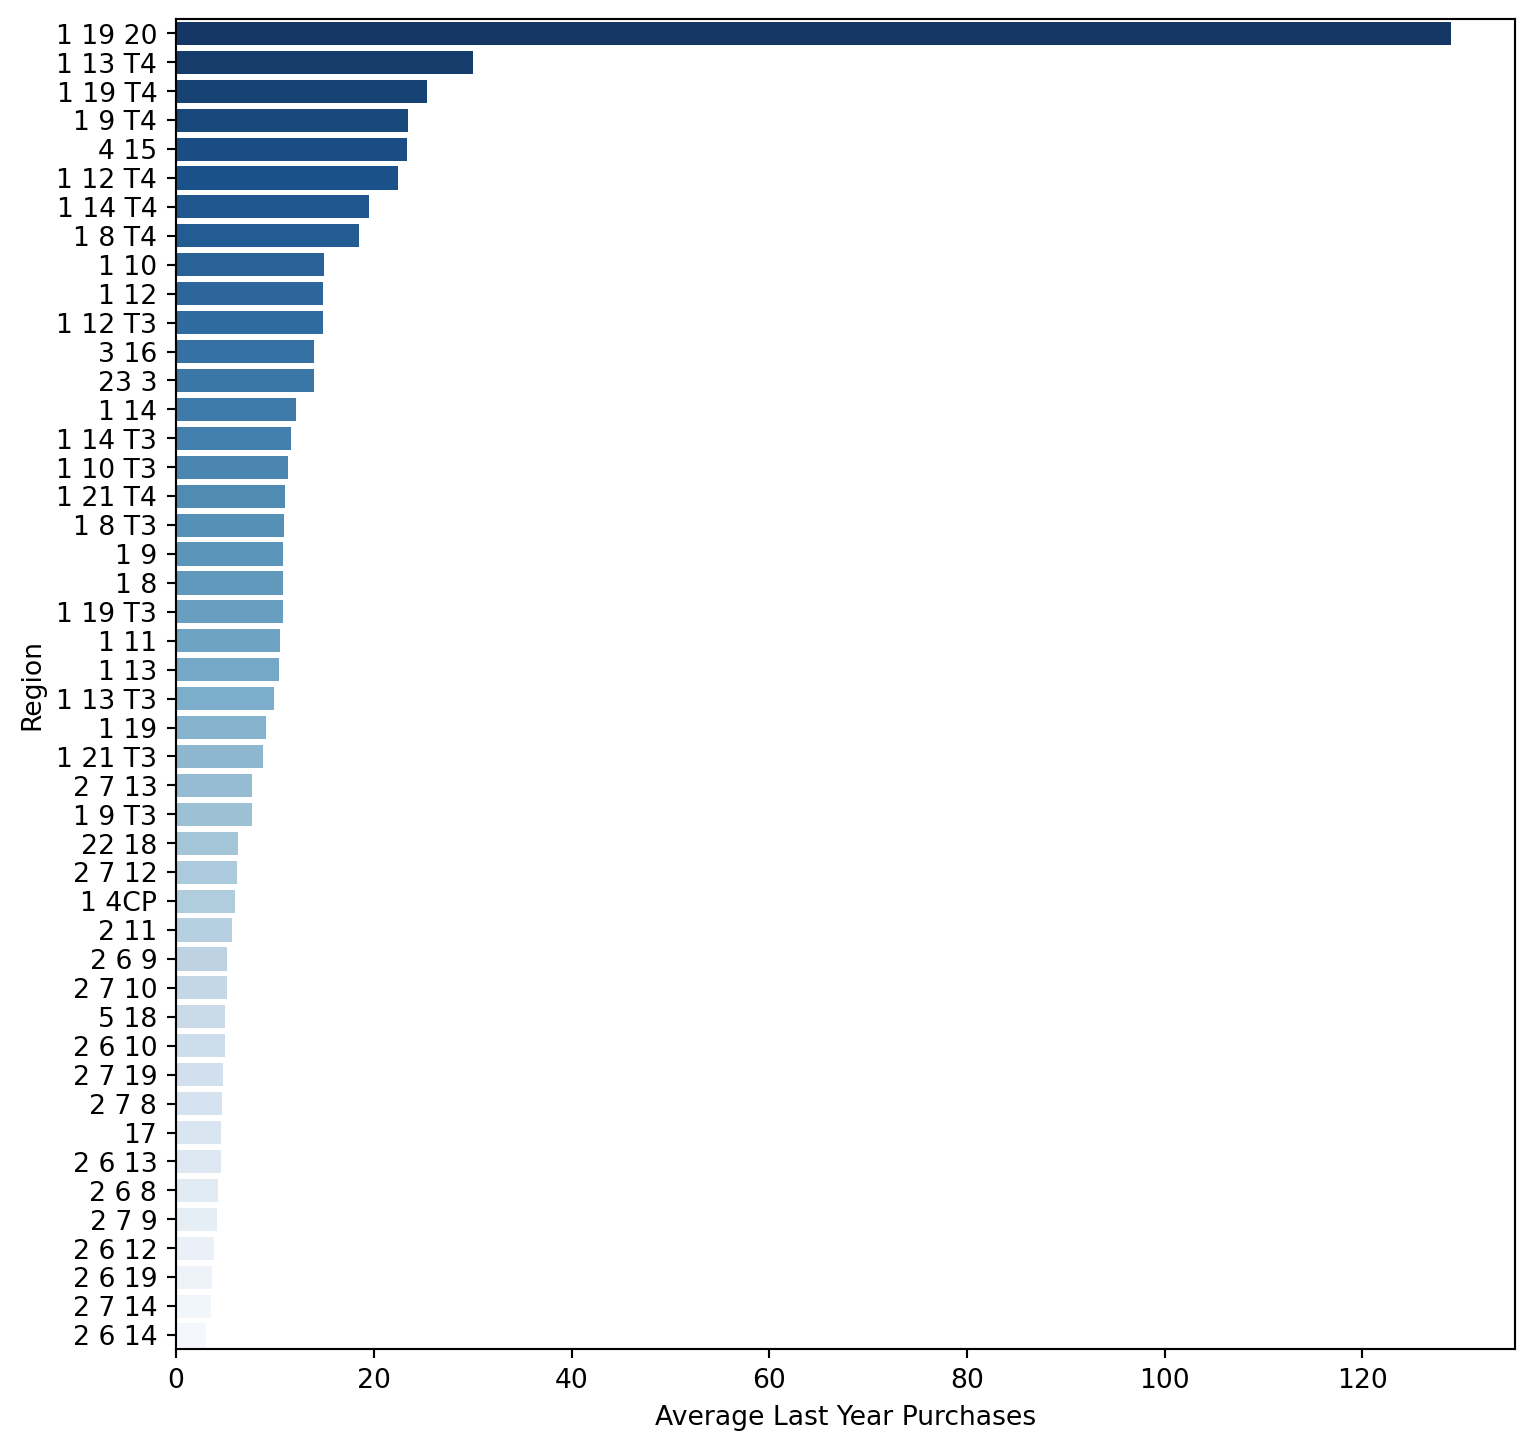

<Figure size 672x480 with 0 Axes>

In [35]:
agg_doctors = doctors.groupby('Region')['last_purchases'].agg('mean').reset_index()
agg_doctors.columns = ['Region','avg_purchases']

plt.figure(figsize = (9,9))
sns.barplot(x = 'avg_purchases', y = 'Region', data = agg_doctors, order=agg_doctors.sort_values('avg_purchases', ascending=False)['Region'], 
palette=sns.color_palette("Blues", 46)[::-1])
plt.xlabel('Average Last Year Purchases')
plt.show()
plt.clf()

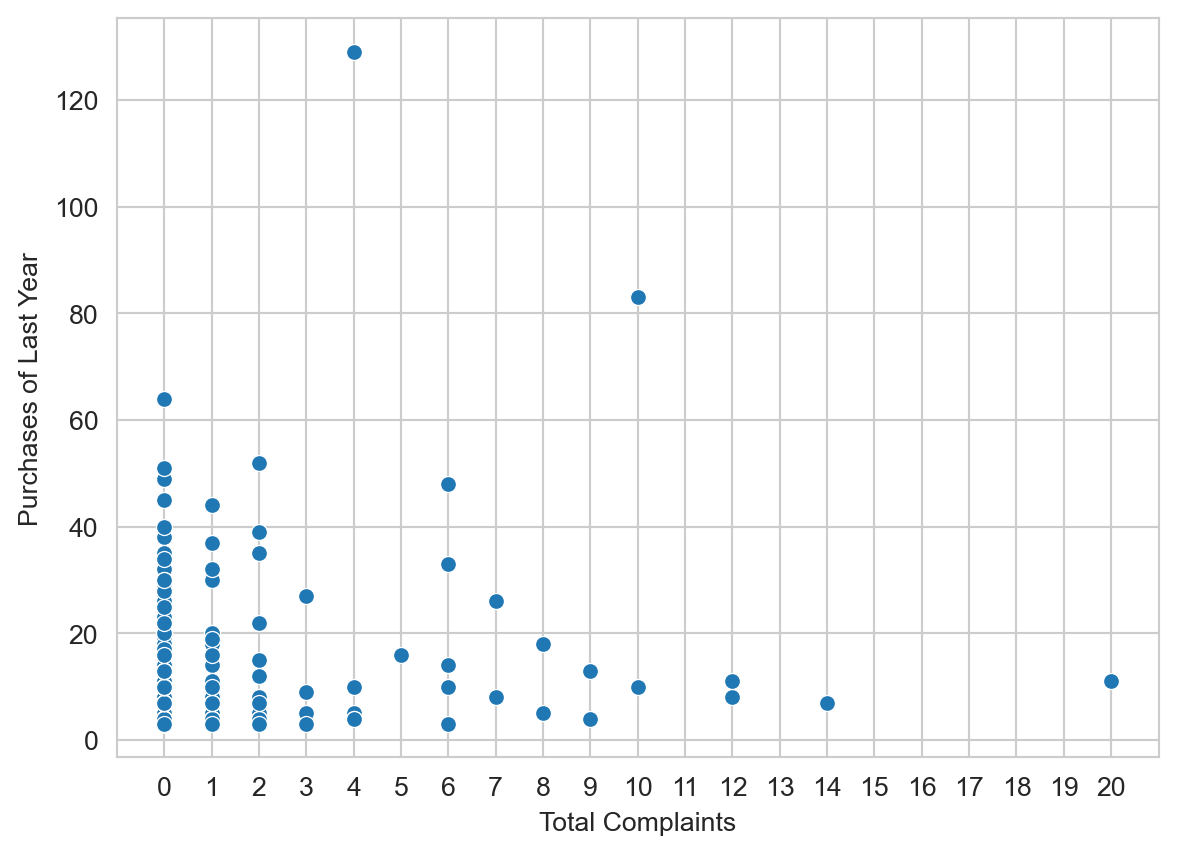

<Figure size 672x480 with 0 Axes>

In [36]:
complaints_purchases = merged_data.loc[:,['DoctorID', 'last_purchases', 'Correct', 'Incorrect', 'R&R', 'Specific', 'total_complaints']]

sns.set_style("whitegrid")
sns.scatterplot(x = 'total_complaints', y = 'last_purchases', data = complaints_purchases)
plt.xlabel('Total Complaints')
plt.ylabel('Purchases of Last Year')
plt.xticks(np.arange(0,21))
plt.show()
plt.clf()

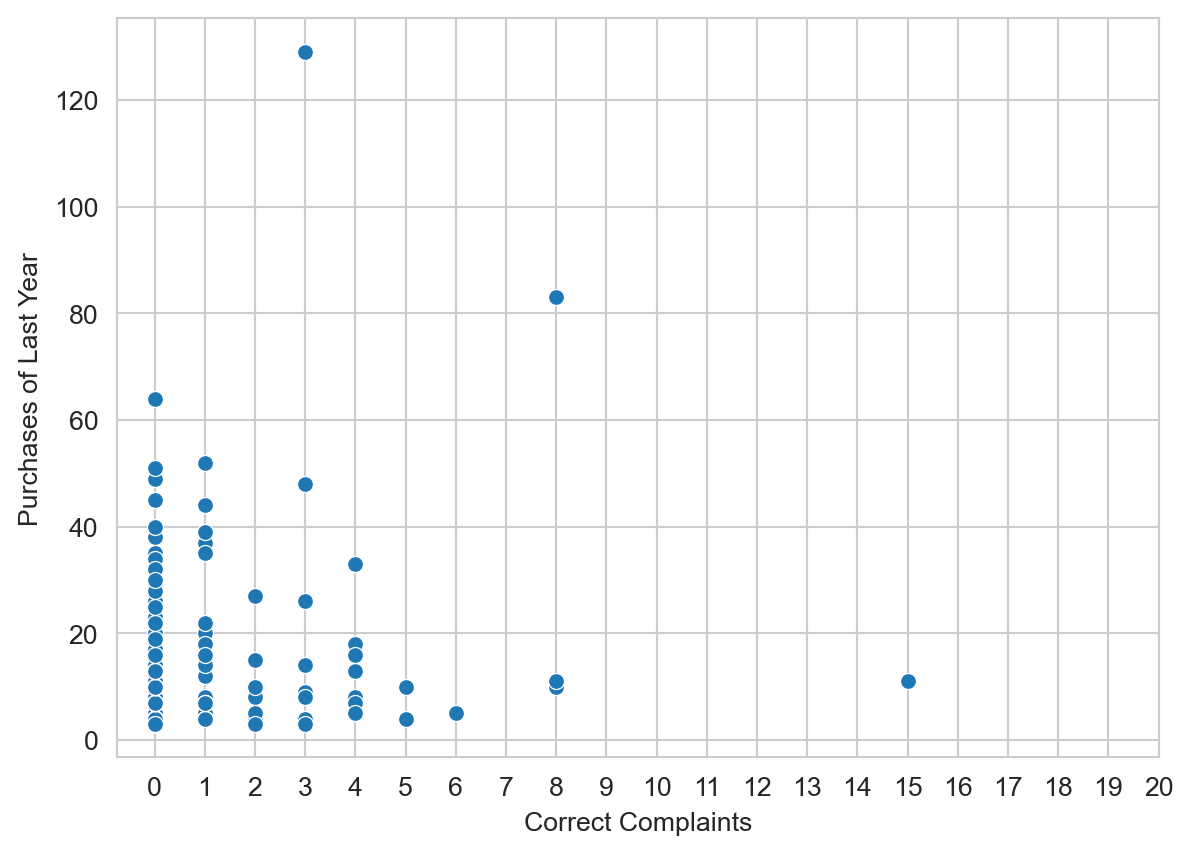

<Figure size 672x480 with 0 Axes>

In [37]:
sns.scatterplot(x = 'Correct', y = 'last_purchases', data = complaints_purchases)
plt.xlabel('Correct Complaints')
plt.ylabel('Purchases of Last Year')
plt.xticks(np.arange(0,21))
plt.show()
plt.clf()

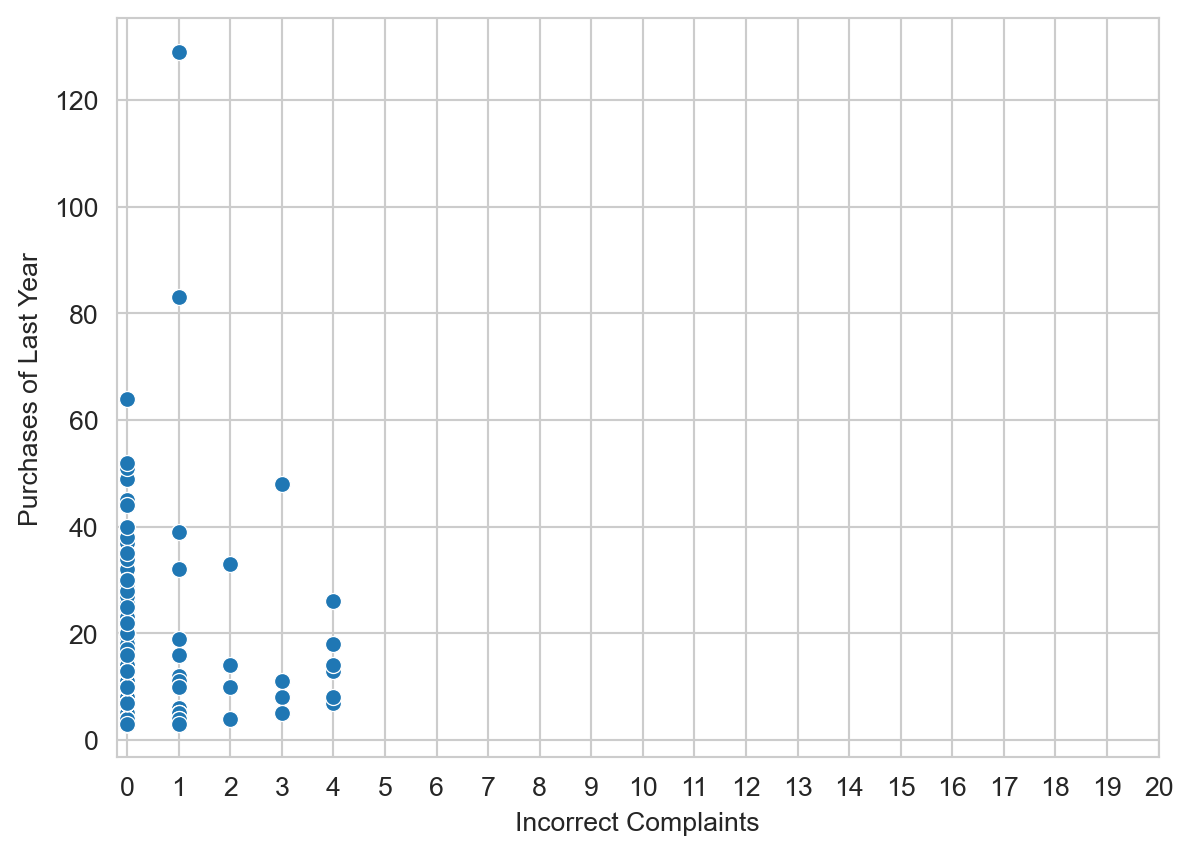

<Figure size 672x480 with 0 Axes>

In [38]:
sns.scatterplot(x = 'Incorrect', y = 'last_purchases', data = complaints_purchases)
plt.xlabel('Incorrect Complaints')
plt.ylabel('Purchases of Last Year')
plt.xticks(np.arange(0,21))
plt.show()
plt.clf()

In [39]:
# columns_to_drop = merged_data.columns.str.contains('Condition')
# columns_to_drop = merged_data.columns[columns_to_drop]
preprocessed_data = merged_data.drop(columns = ['DoctorID', 'Region', 'Satisfaction_na'])

preprocessed_data = pd.get_dummies(data = preprocessed_data, columns = ['Category', 'Rank'], drop_first = True).replace({True:1, False:0})

scaler = StandardScaler()

excluding_sat = preprocessed_data.columns!='Satisfaction'

preprocessed_data.loc[:,excluding_sat] = scaler.fit_transform(preprocessed_data.loc[:,excluding_sat])

In [40]:
knn_imputer = KNNImputer(n_neighbors = 2)
knn_imputed = knn_imputer.fit_transform(preprocessed_data)
merged_knn_imputed = preprocessed_data.copy(deep = True)
merged_knn_imputed.iloc[:,:] = knn_imputed
display(merged_knn_imputed.loc[:, 'Satisfaction'].head())

0     53.850
1    100.000
2     88.395
3     88.395
4     76.790
Name: Satisfaction, dtype: float64

In [41]:
#| eval: false
iter_imputer = IterativeImputer(sample_posterior = True)
iter_imputer.fit(preprocessed_data)
iter_imputer.n_iter_

iter_imputed = iter_imputer.transform(preprocessed_data)
merged_iter_imputed = preprocessed_data.copy(deep = True)
merged_iter_imputed.iloc[:,:] = iter_imputed
display(merged_iter_imputed.loc[:, 'Satisfaction'].head())

In [42]:
#| eval: false
merged_knn_imputed['Satisfaction_NA'] = preprocessed_data['Satisfaction'].isnull()

merged_iter_imputed['Satisfaction_NA'] = preprocessed_data['Satisfaction'].isnull()

In [43]:
#| eval: false
sns.kdeplot(x = 'Satisfaction', hue = 'Satisfaction_NA', data = merged_knn_imputed)
sns.rugplot(x = 'Satisfaction', hue = 'Satisfaction_NA', data = merged_knn_imputed)
plt.title('Satisfaction Imputation with KNN Method')
plt.show()
plt.clf()

sns.kdeplot(x = 'Satisfaction', hue = 'Satisfaction_NA', data = merged_iter_imputed)
sns.rugplot(x = 'Satisfaction', hue = 'Satisfaction_NA', data = merged_iter_imputed)
plt.title('Satisfaction Imputation with Iterative Method')
plt.show()
plt.clf()

In [44]:
# merged_knn_imputed.drop('Satisfaction_NA', axis = 1, inplace = True)
merged_knn_imputed.iloc[:,:] = scaler.fit_transform(merged_knn_imputed)

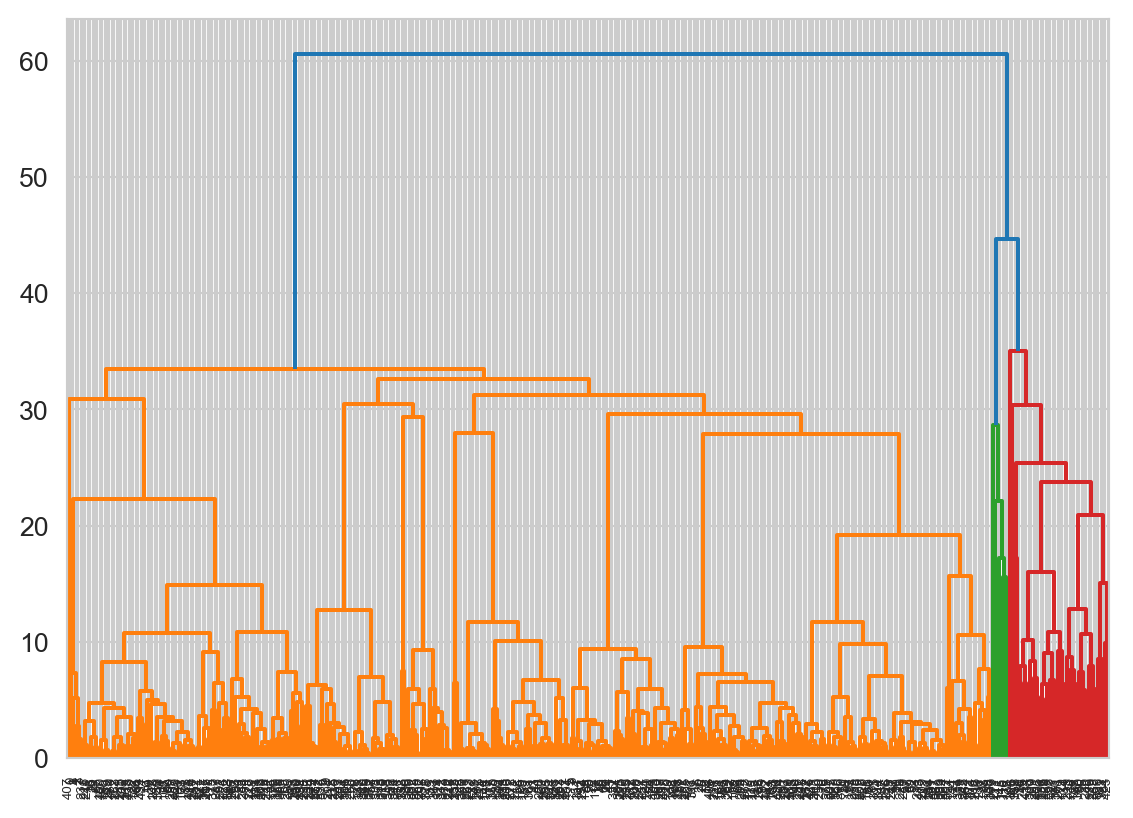

<Figure size 672x480 with 0 Axes>

In [45]:
link = linkage(merged_knn_imputed, method = 'ward', metric = 'euclidean')

dendrogram(link)
plt.show()
plt.clf()

merged_data['hierarchy_clust'] = fcluster(link, 3, criterion = 'maxclust')

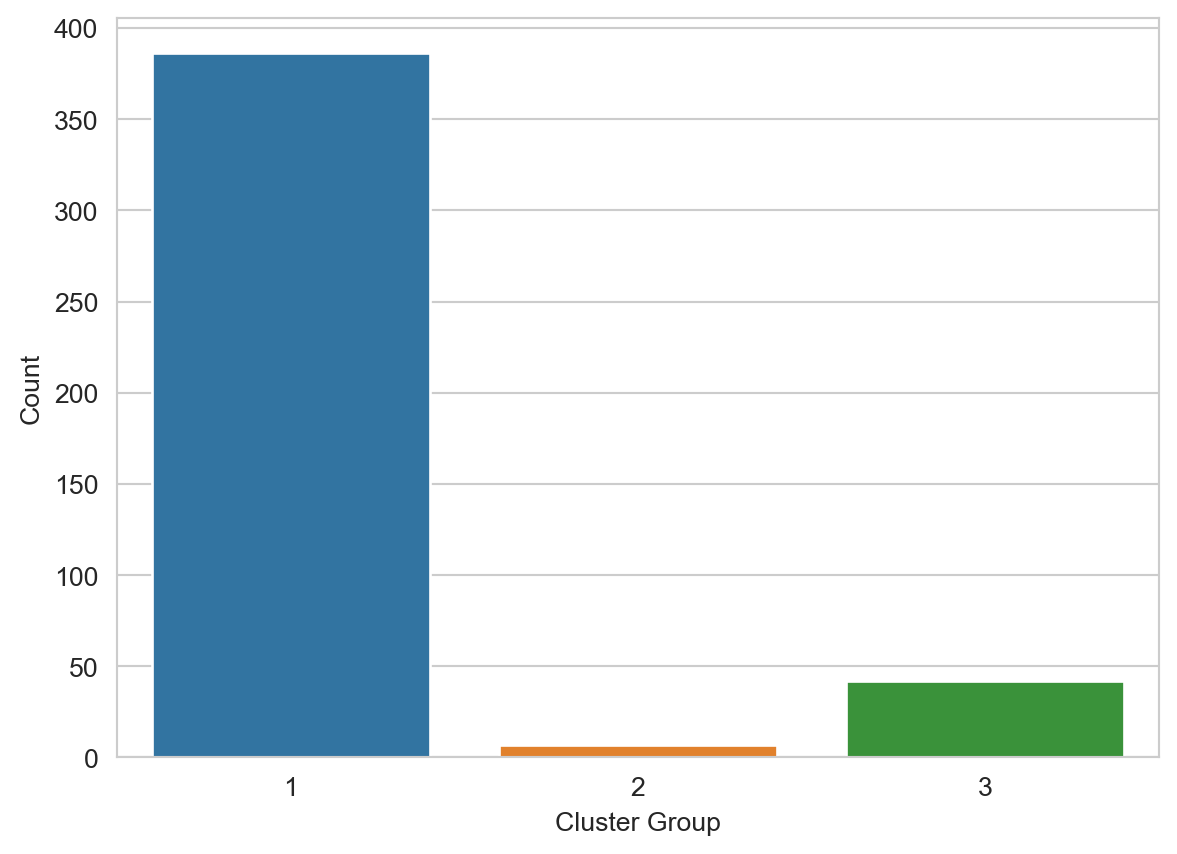

<Figure size 672x480 with 0 Axes>

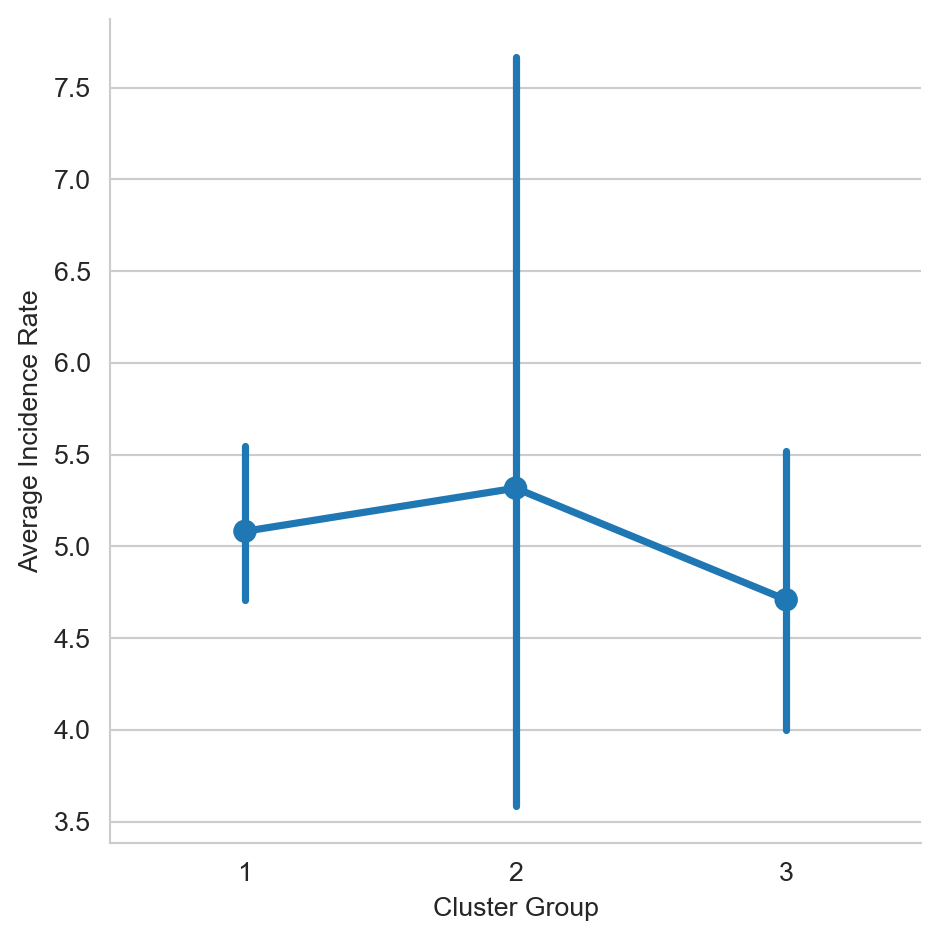

<Figure size 672x480 with 0 Axes>

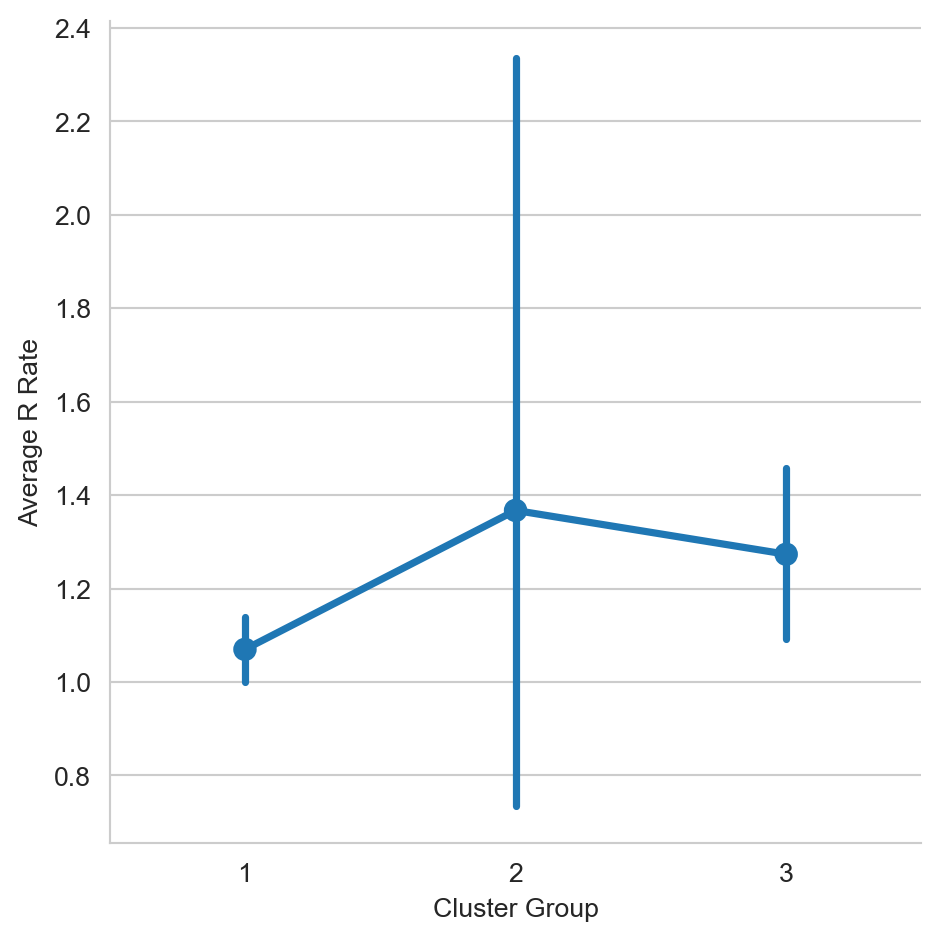

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning:

Mean of empty slice



<Figure size 672x480 with 0 Axes>

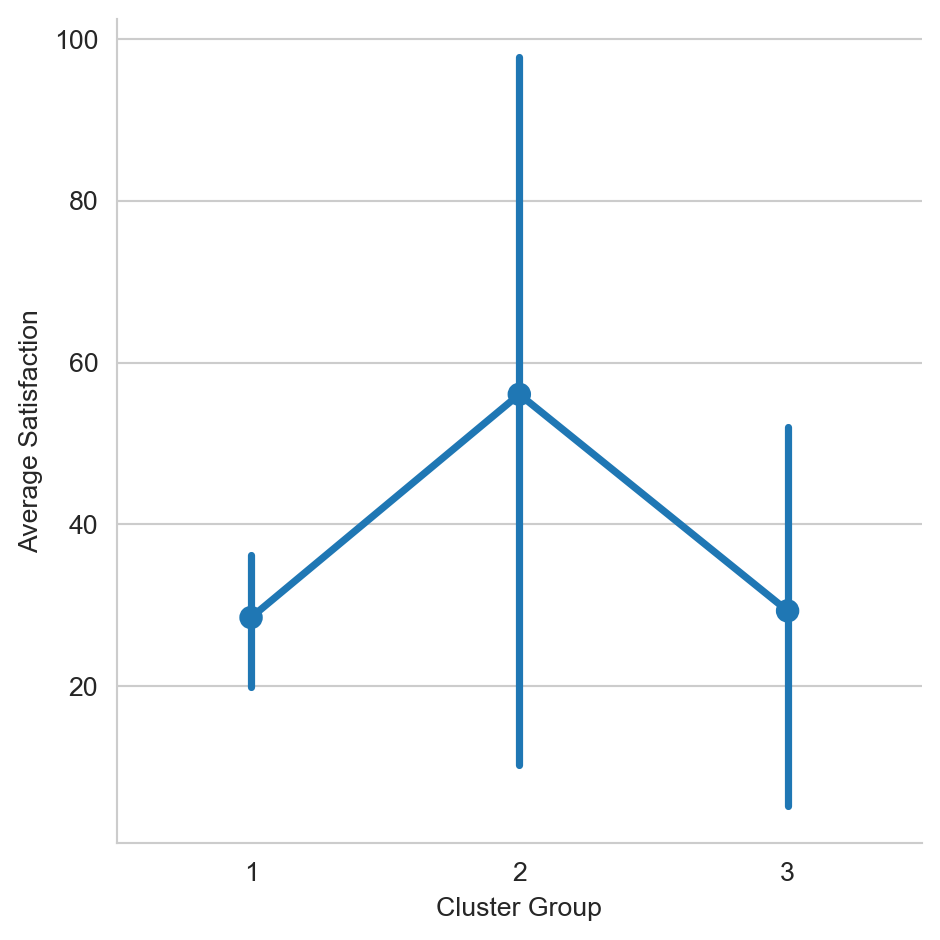

<Figure size 672x480 with 0 Axes>

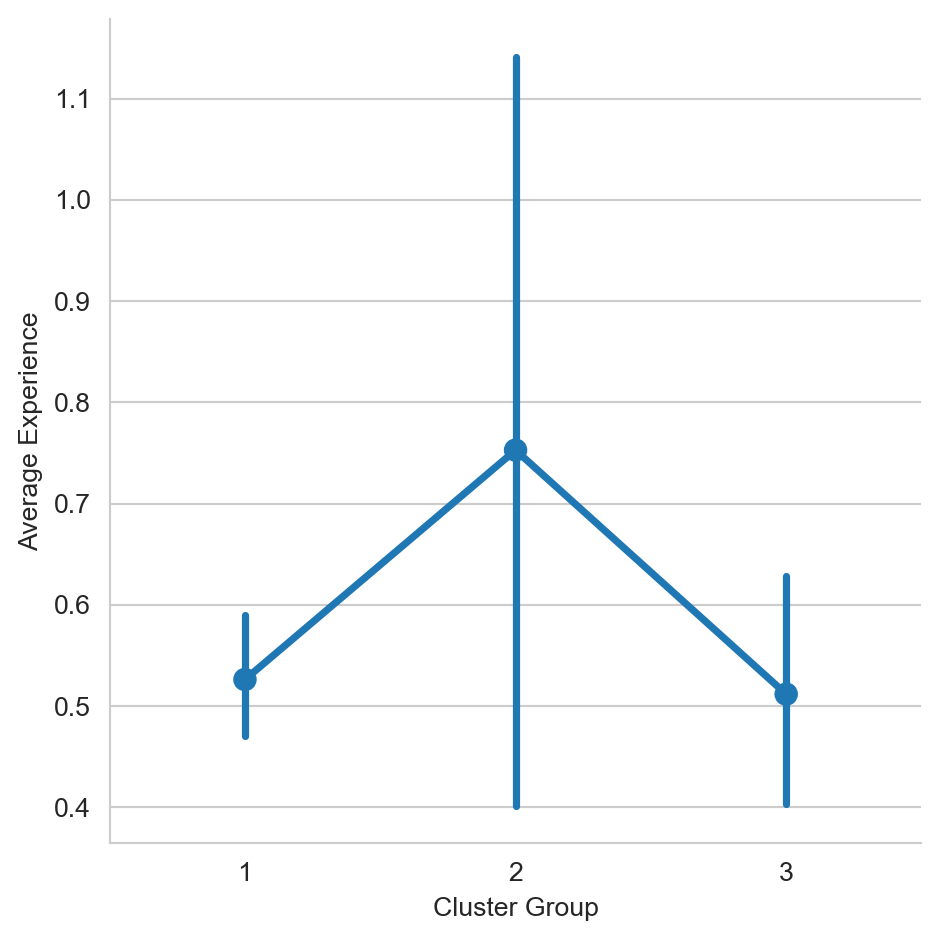

<Figure size 672x480 with 0 Axes>

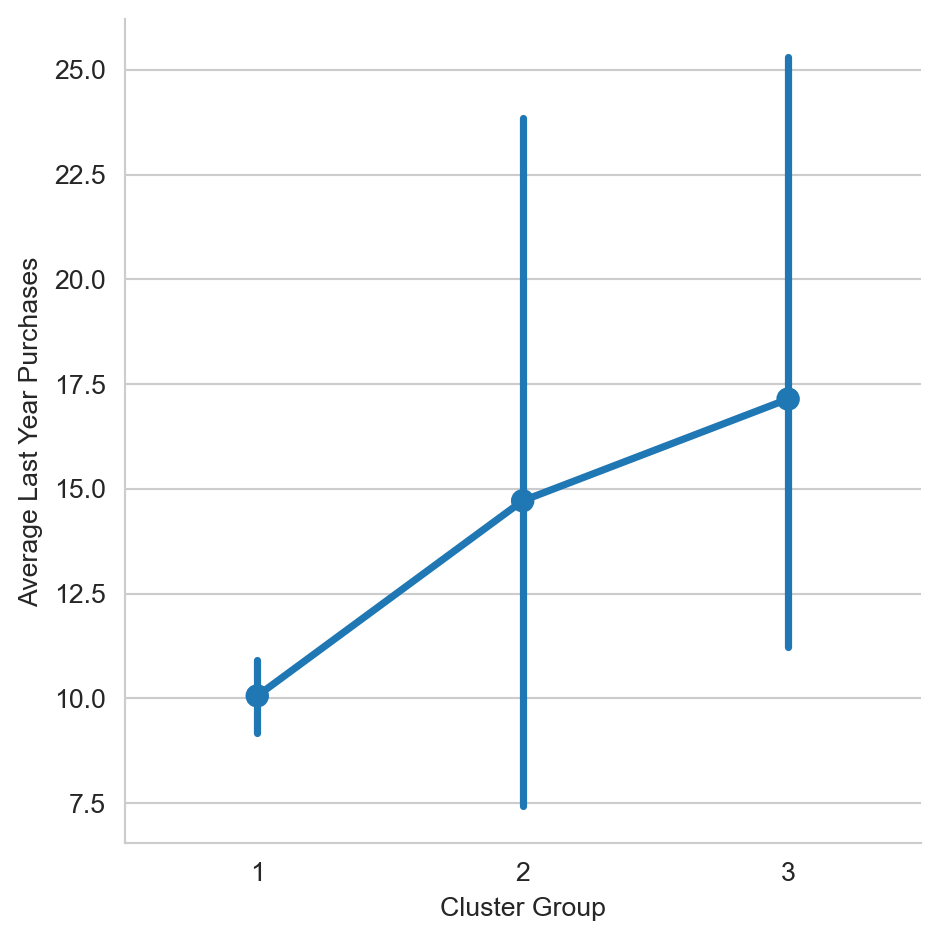

<Figure size 672x480 with 0 Axes>

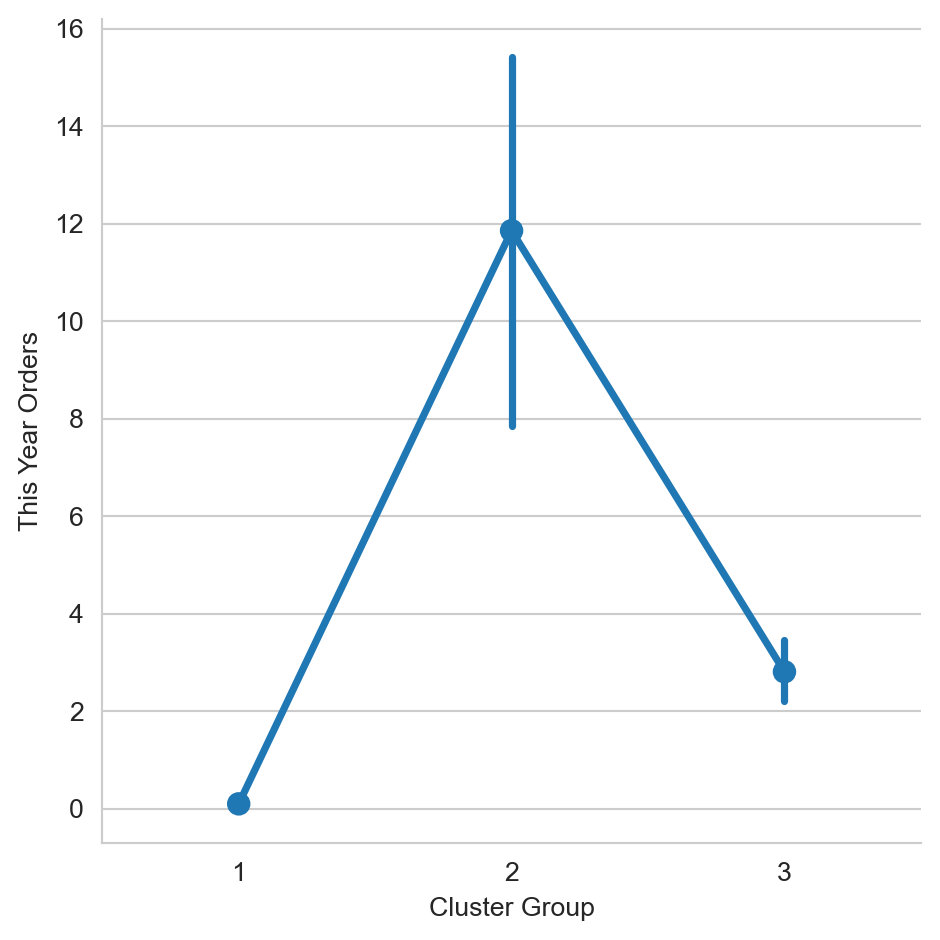

<Figure size 672x480 with 0 Axes>

In [46]:
sns.set_style("whitegrid")
sns.countplot(x = 'hierarchy_clust', data = merged_data)
plt.xlabel('Cluster Group')
plt.ylabel('Count')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust', y = 'Incidence rate', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group')
plt.ylabel('Average Incidence Rate')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust', y = 'R rate', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group')
plt.ylabel('Average R Rate')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust', y = 'Satisfaction', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group')
plt.ylabel('Average Satisfaction')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust', y = 'Experience', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group')
plt.ylabel('Average Experience')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust', y = 'last_purchases', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group')
plt.ylabel('Average Last Year Purchases')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust', y = 'total_orders', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group')
plt.ylabel('This Year Orders')
plt.show()
plt.clf()

In [47]:
pca_mdl = KernelPCA(n_components = 5,random_state = 10, kernel = 'rbf')
pca_mdl.fit(merged_knn_imputed)
transformed_pca = pca_mdl.transform(merged_knn_imputed)

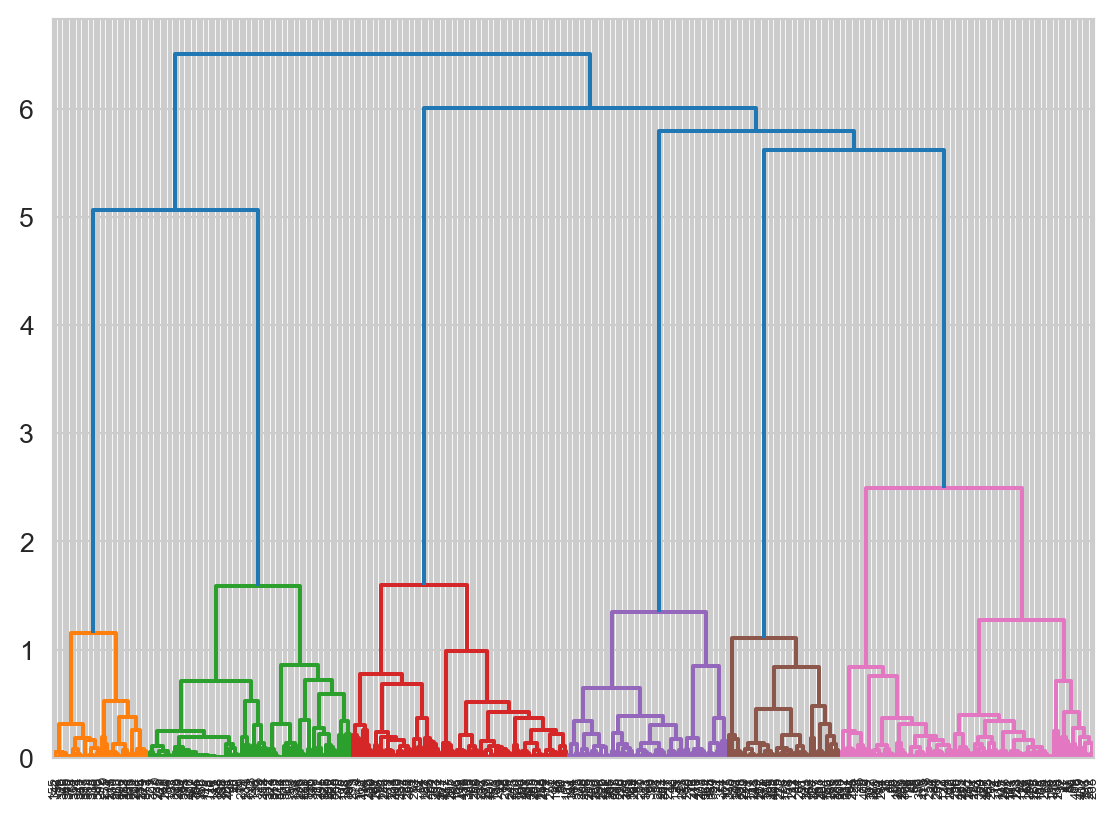

<Figure size 672x480 with 0 Axes>

In [48]:
link_pca = linkage(transformed_pca, method = 'ward', metric = 'euclidean')

dendrogram(link_pca)
plt.show()
plt.clf()

merged_data['hierarchy_clust_pca'] = fcluster(link_pca, 6, criterion = 'maxclust')

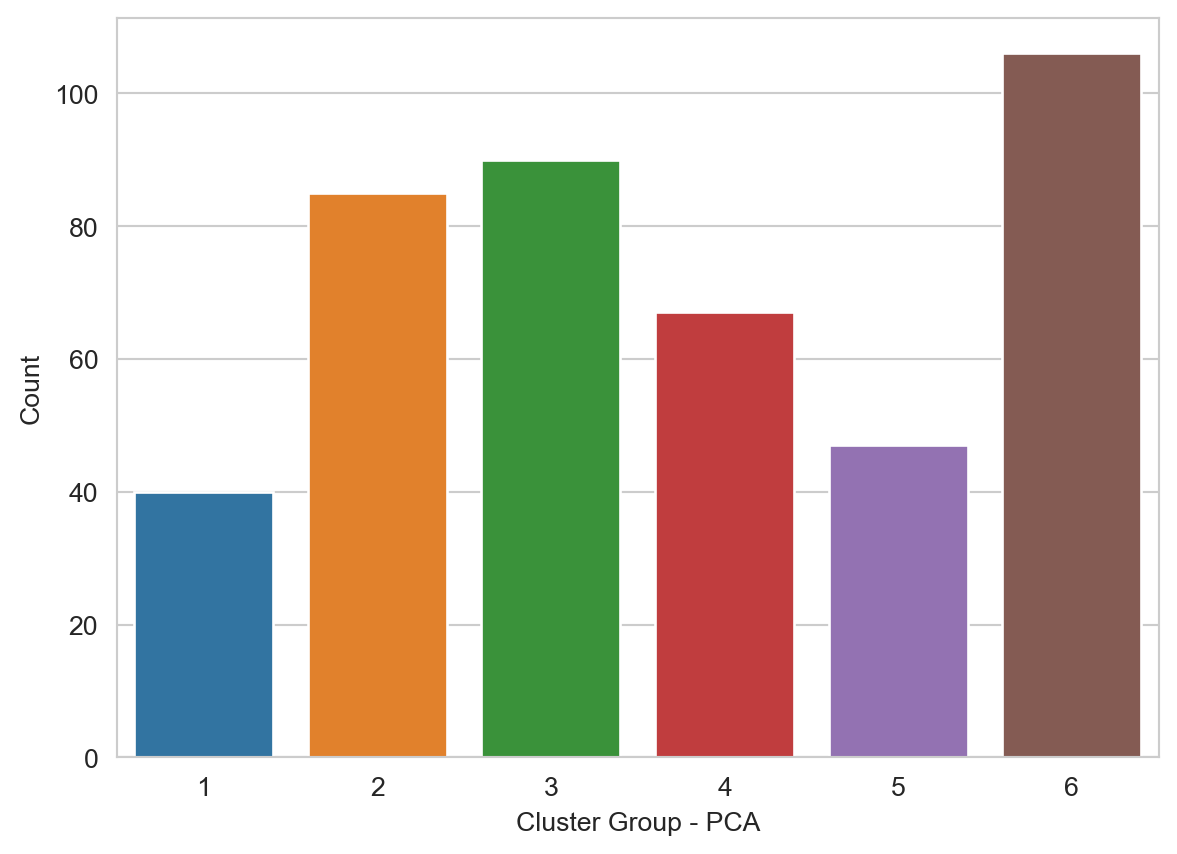

<Figure size 672x480 with 0 Axes>

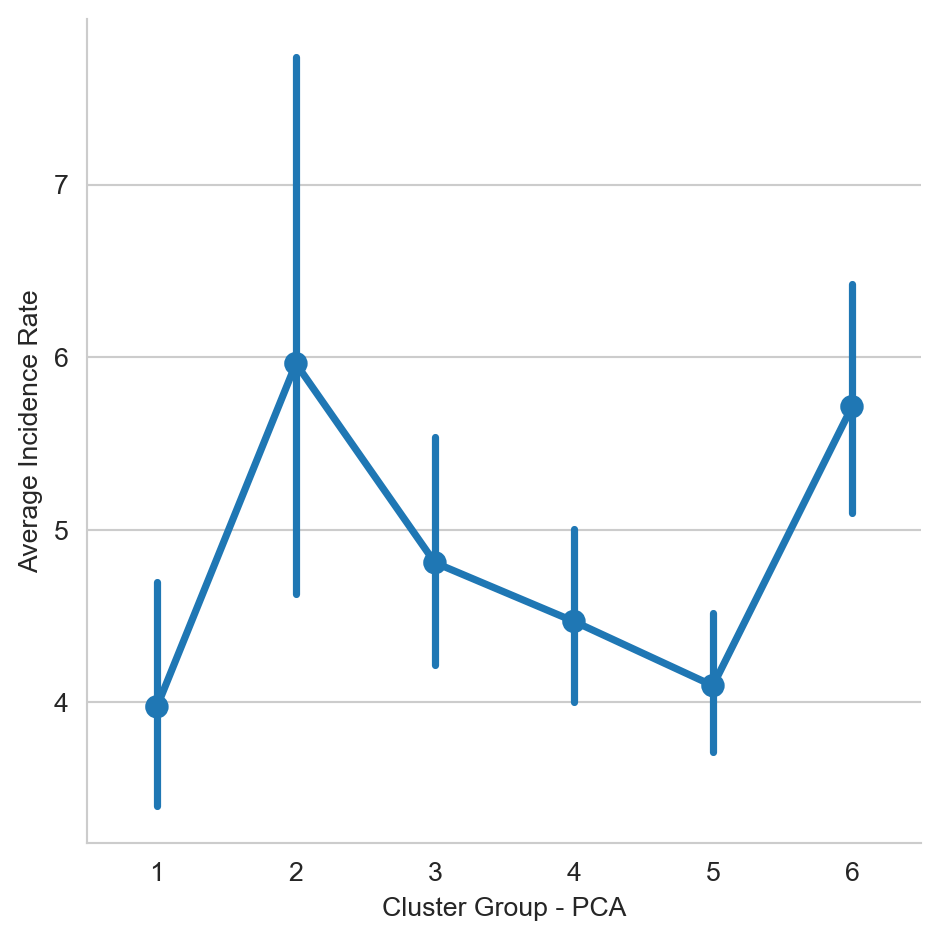

<Figure size 672x480 with 0 Axes>

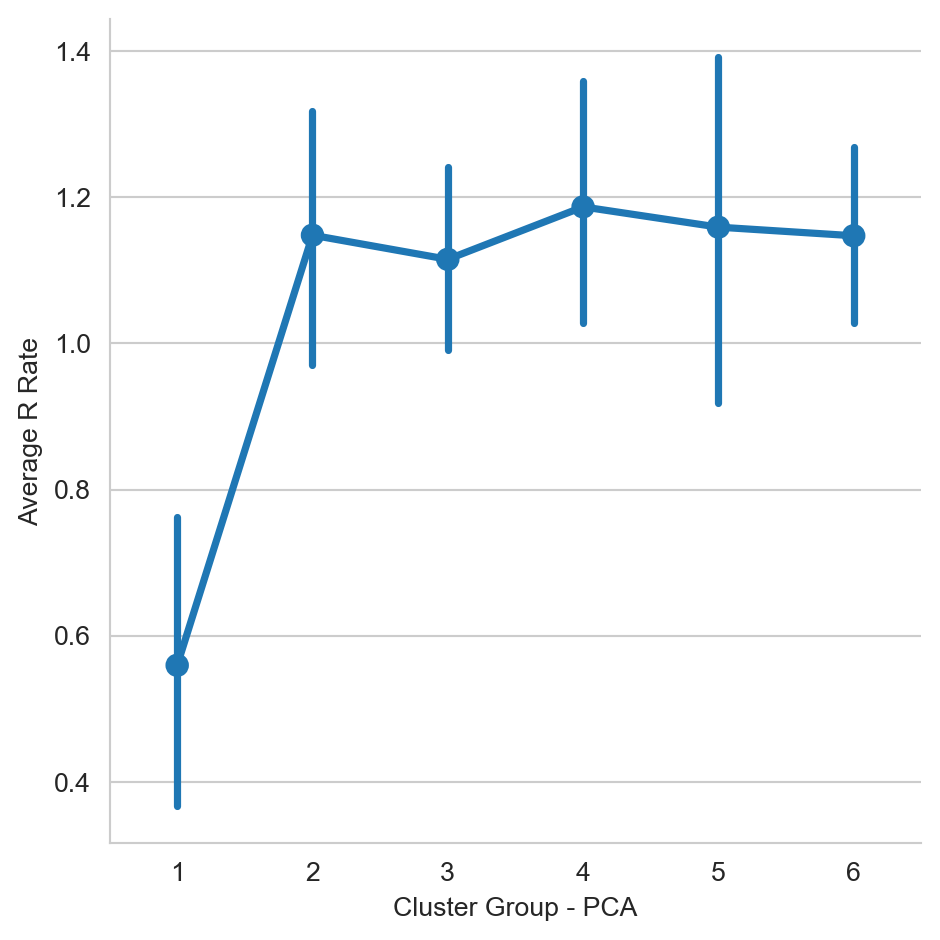

<Figure size 672x480 with 0 Axes>

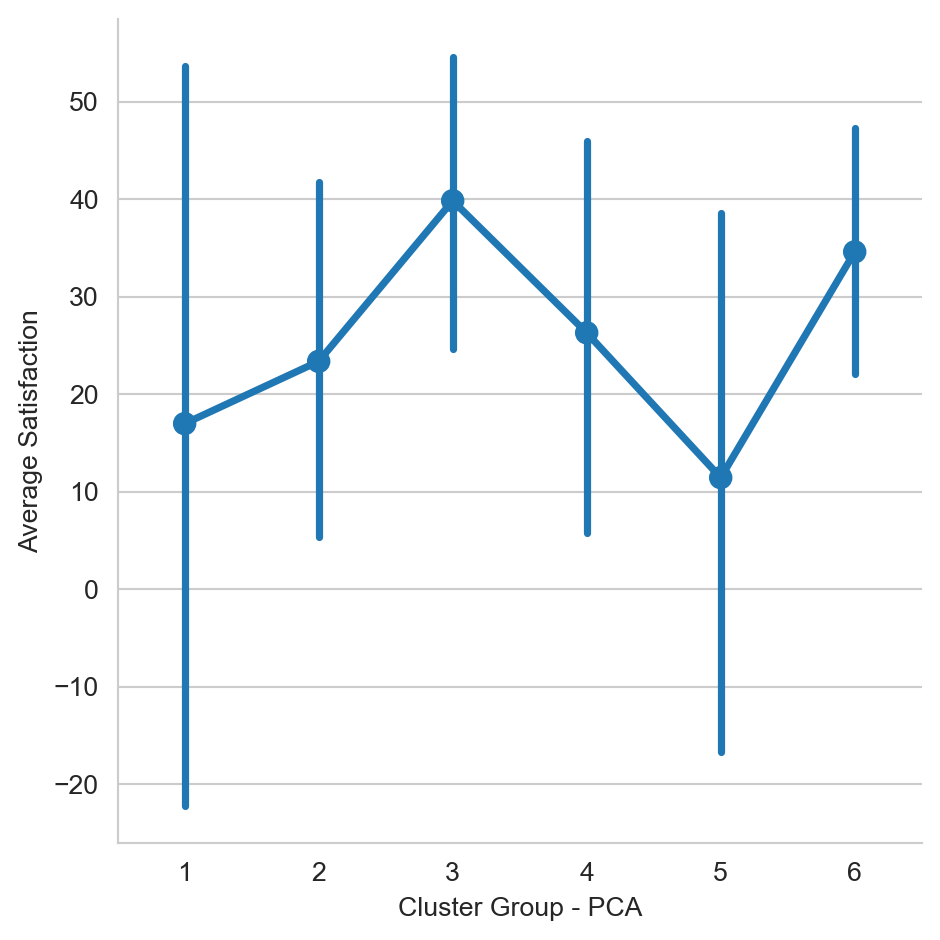

<Figure size 672x480 with 0 Axes>

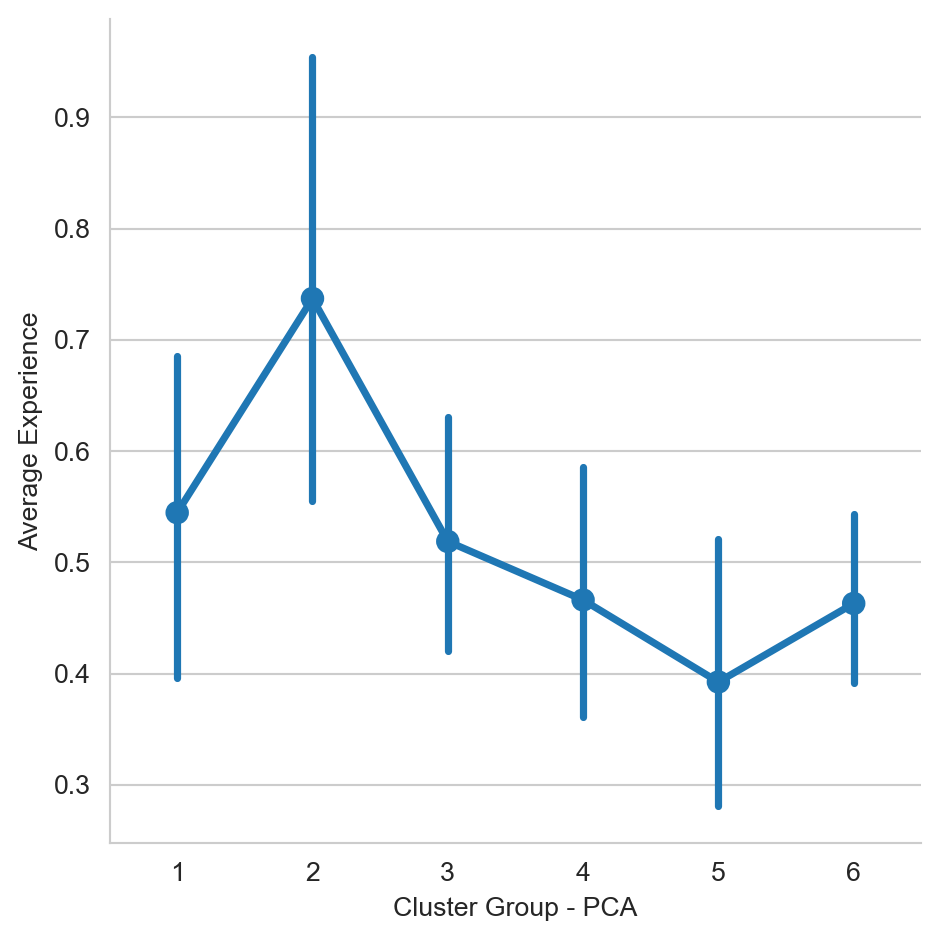

<Figure size 672x480 with 0 Axes>

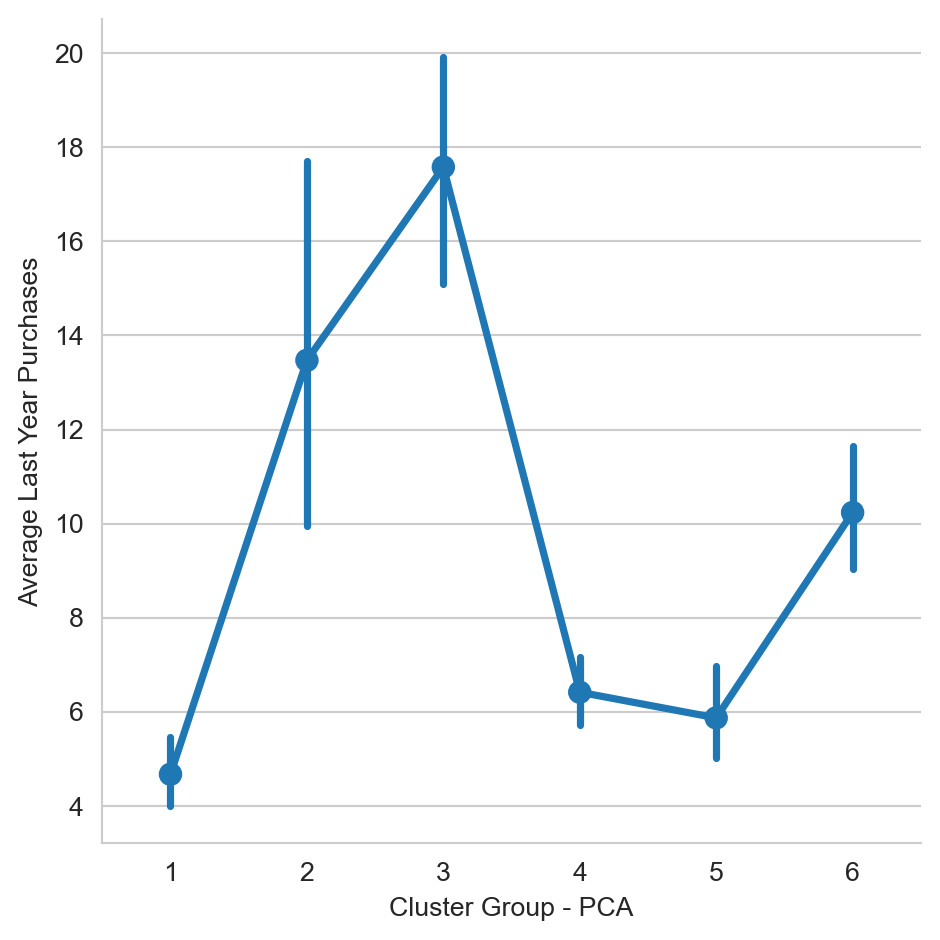

<Figure size 672x480 with 0 Axes>

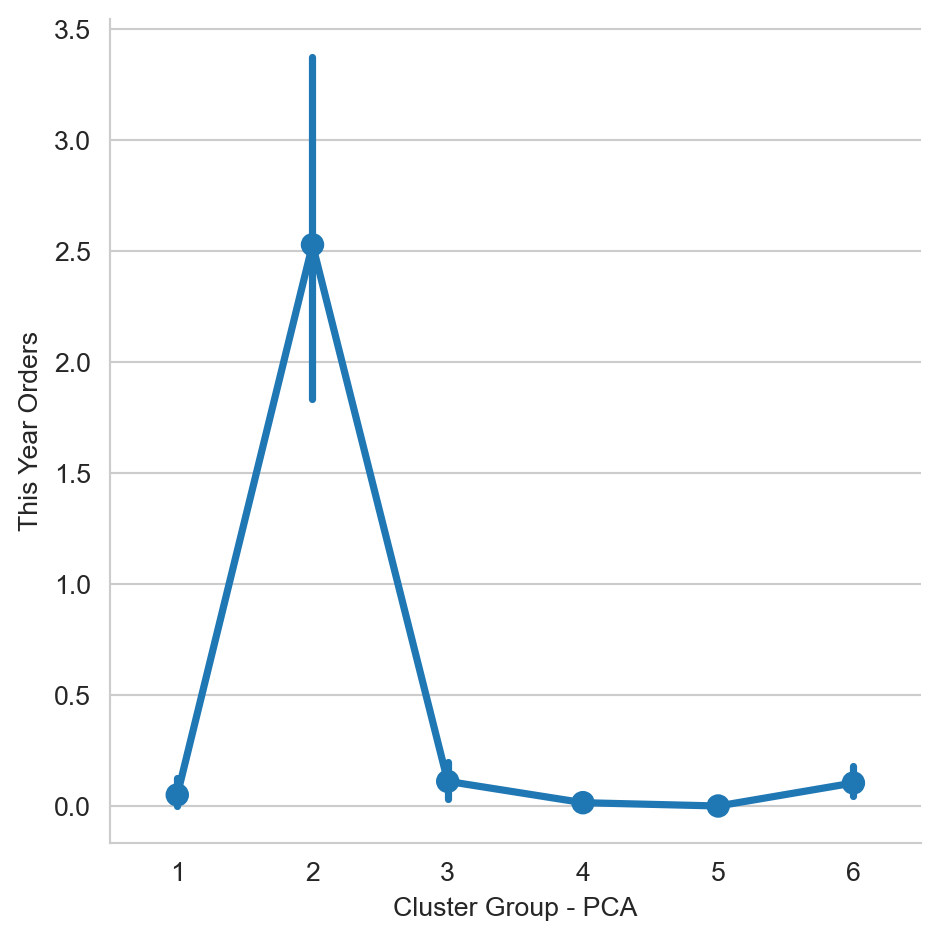

<Figure size 672x480 with 0 Axes>

In [49]:
sns.set_style("whitegrid")
sns.countplot(x = 'hierarchy_clust_pca', data = merged_data)
plt.xlabel('Cluster Group - PCA')
plt.ylabel('Count')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust_pca', y = 'Incidence rate', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group - PCA')
plt.ylabel('Average Incidence Rate')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust_pca', y = 'R rate', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group - PCA')
plt.ylabel('Average R Rate')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust_pca', y = 'Satisfaction', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group - PCA')
plt.ylabel('Average Satisfaction')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust_pca', y = 'Experience', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group - PCA')
plt.ylabel('Average Experience')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust_pca', y = 'last_purchases', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group - PCA')
plt.ylabel('Average Last Year Purchases')
plt.show()
plt.clf()

sns.catplot(x = 'hierarchy_clust_pca', y = 'total_orders', kind = 'point', data = merged_data)
plt.xlabel('Cluster Group - PCA')
plt.ylabel('This Year Orders')
plt.show()
plt.clf()

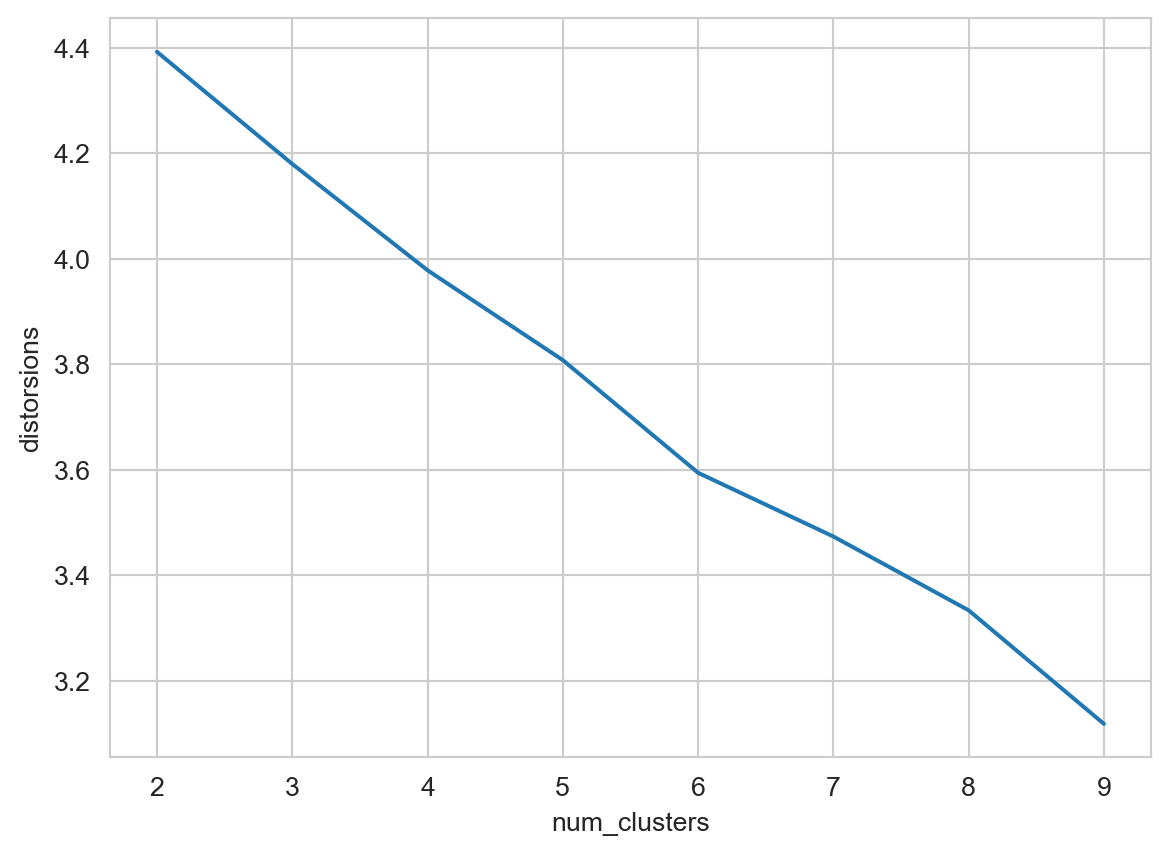

<Figure size 672x480 with 0 Axes>

In [50]:
distorsions = []
num_clusters = range(2,10)

for i in num_clusters:
    centroids, distorsion = kmeans(merged_knn_imputed, i)
    distorsions.append(distorsion)
  
elbow_plot_df = pd.DataFrame({'num_clusters':num_clusters, 'distorsions':distorsions})

sns.lineplot(x = 'num_clusters', y = 'distorsions', data = elbow_plot_df)
plt.show()
plt.clf()

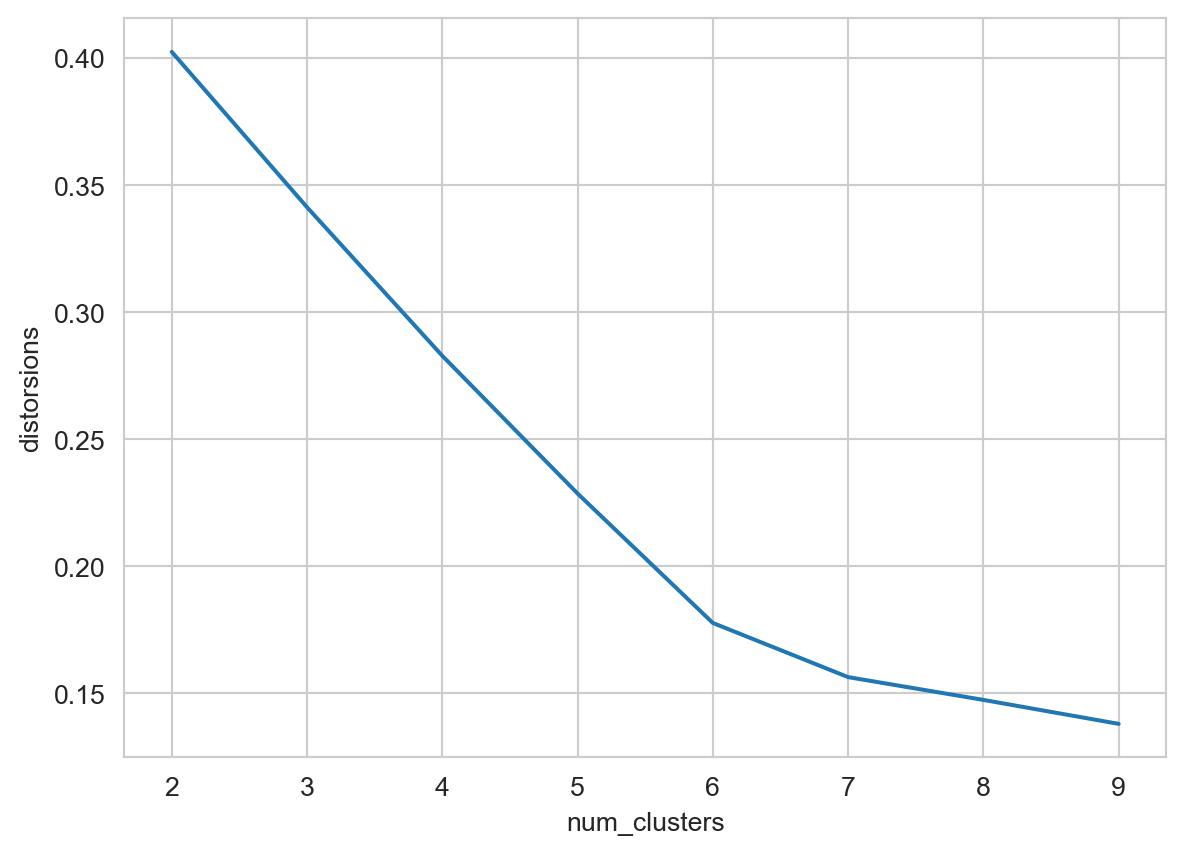

<Figure size 672x480 with 0 Axes>

In [51]:
distorsions = []
num_clusters = range(2,10)

for i in num_clusters:
    centroids, distorsion = kmeans(transformed_pca, i)
    distorsions.append(distorsion)
  
elbow_plot_df = pd.DataFrame({'num_clusters':num_clusters, 'distorsions':distorsions})

sns.lineplot(x = 'num_clusters', y = 'distorsions', data = elbow_plot_df)
plt.show()
plt.clf()

In [52]:
merged_data.rename(columns = {'hierarchy_clust_pca':'Cluster Group'}, inplace = True)
cluster_count = merged_data.groupby('Cluster Group').size().reset_index()
cluster_count.rename(columns = {0:'Count'}, inplace = True)

display(cluster_count)

,Cluster Group,Count
0,1,40
1,2,85
2,3,90
3,4,67
4,5,47
5,6,106


In [53]:
plot_colors = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']

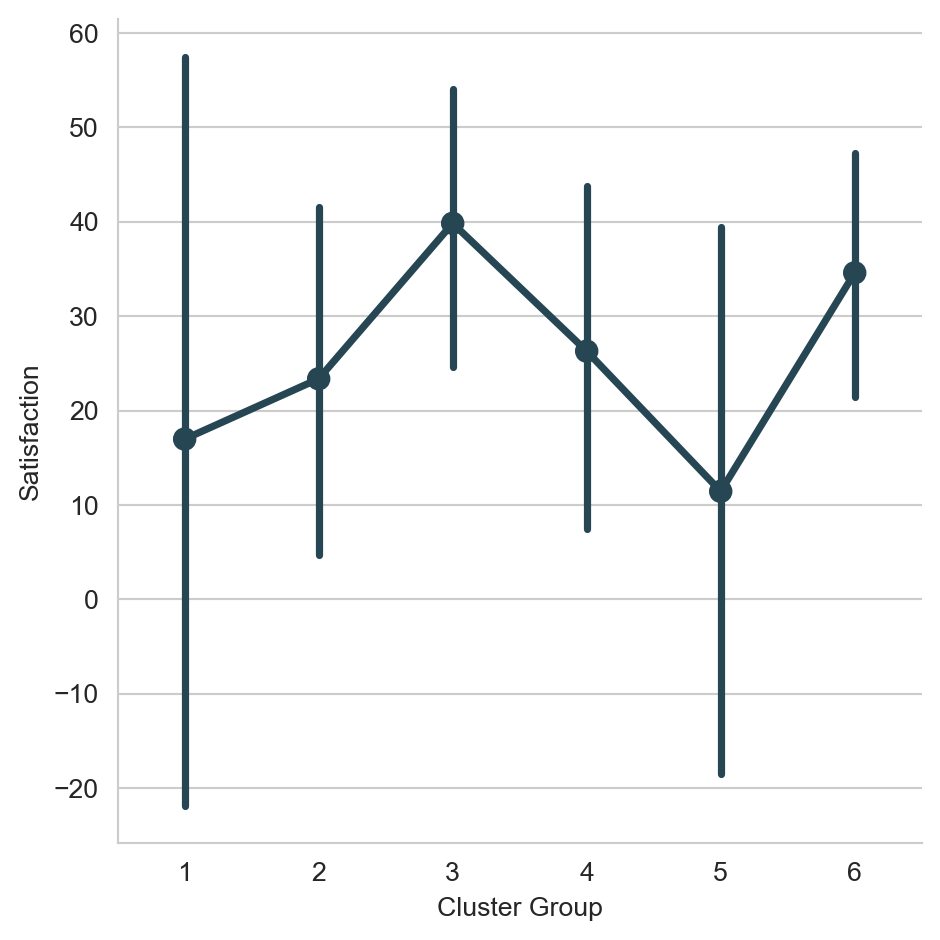

<Figure size 672x480 with 0 Axes>

In [54]:
sns.catplot(x = 'Cluster Group', y = 'Satisfaction', kind = 'point', data = merged_data, color = plot_colors[0])
plt.show()
plt.clf()

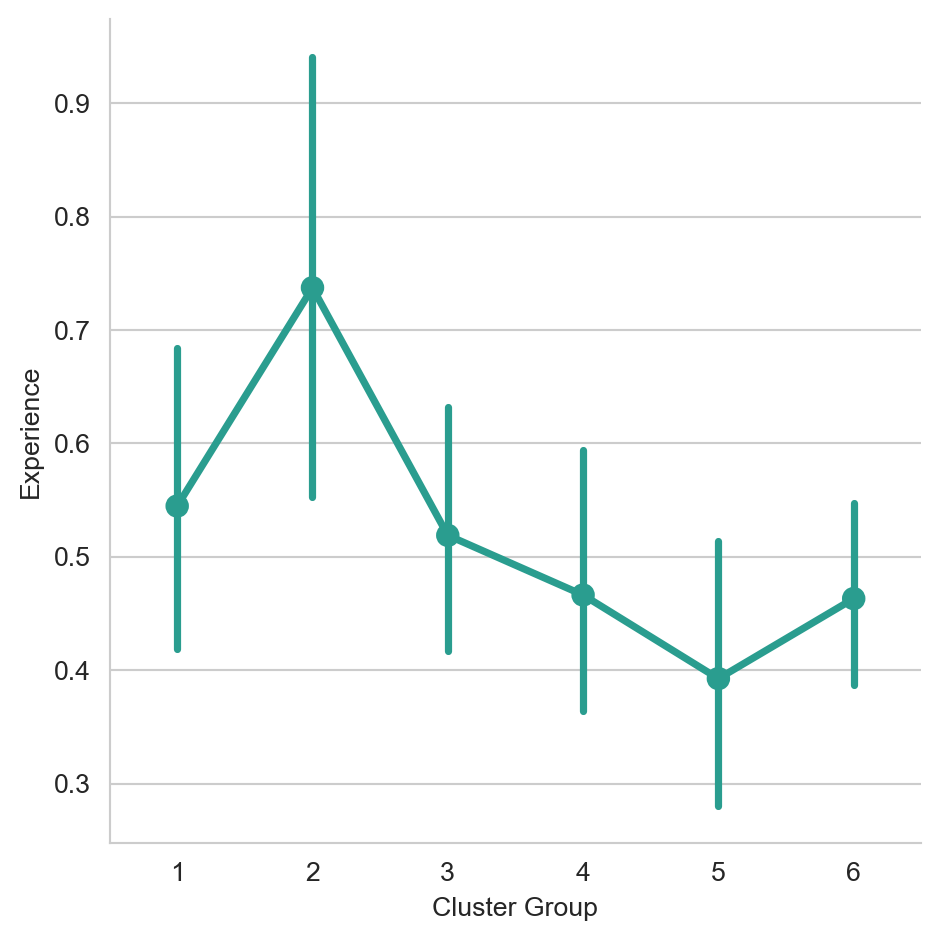

<Figure size 672x480 with 0 Axes>

In [55]:
sns.catplot(x = 'Cluster Group', y = 'Experience', kind = 'point', data = merged_data, color = plot_colors[1])
plt.show()
plt.clf()

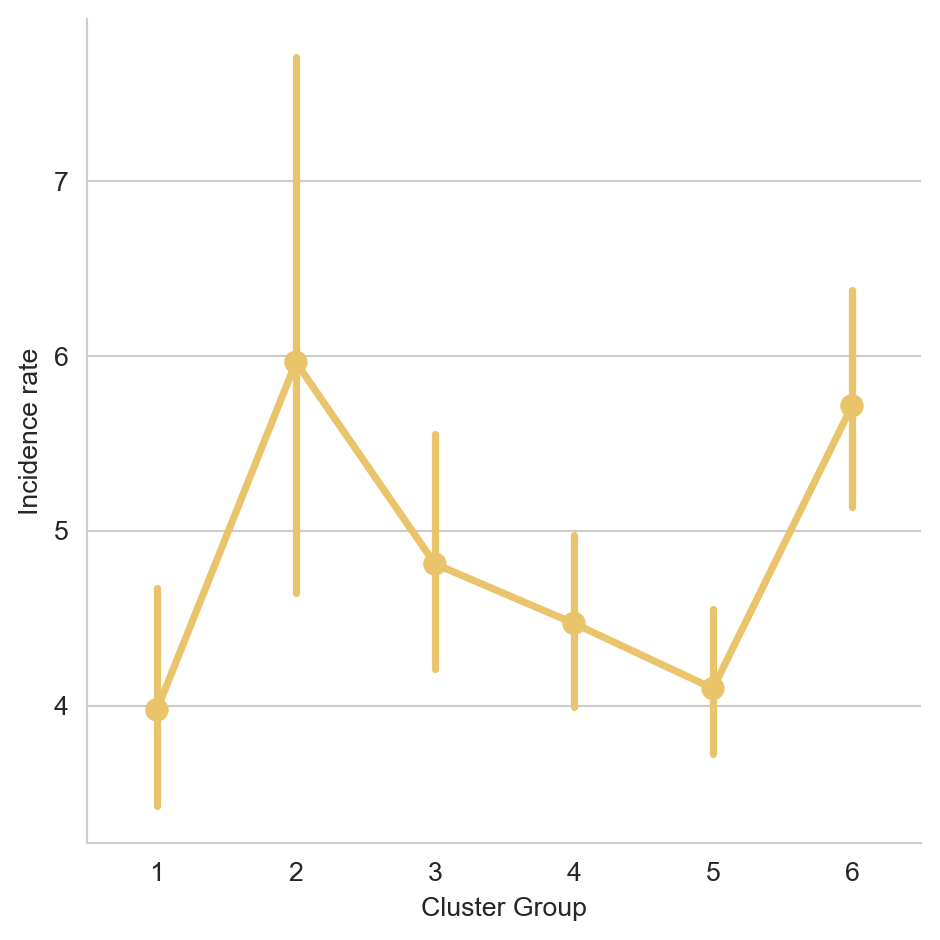

<Figure size 672x480 with 0 Axes>

In [56]:
sns.catplot(x = 'Cluster Group', y = 'Incidence rate', kind = 'point', data = merged_data, color = plot_colors[2])
plt.show()
plt.clf()

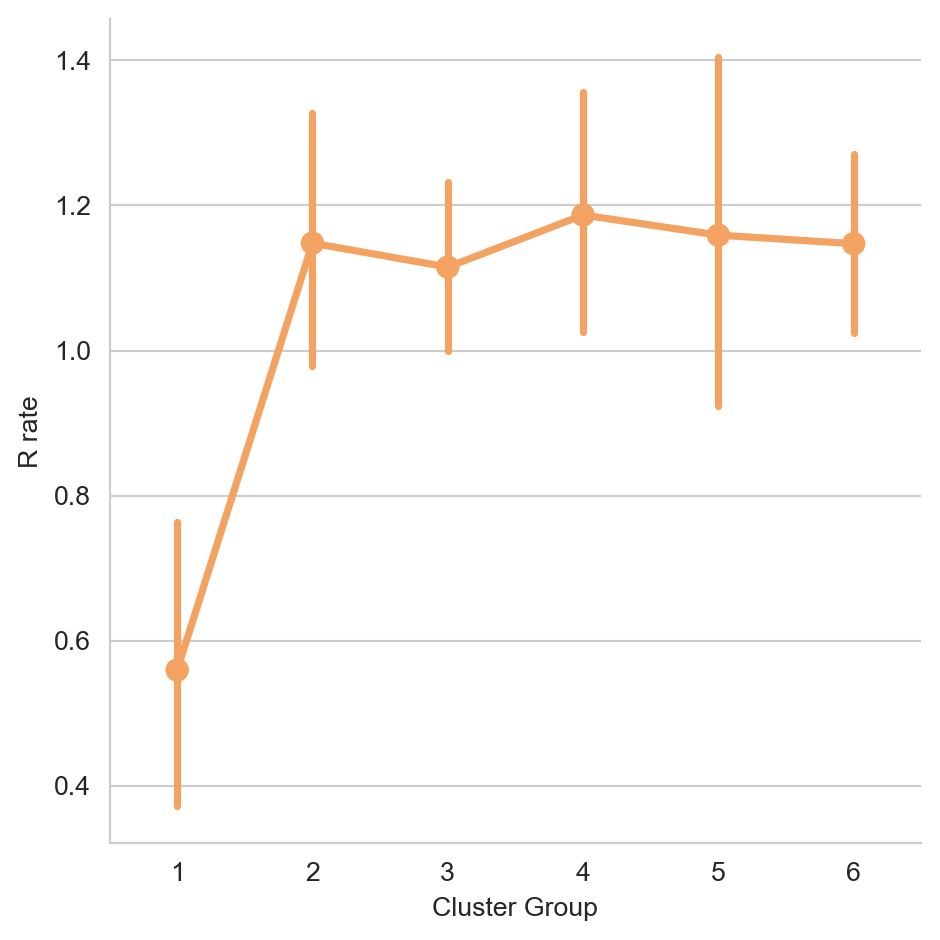

<Figure size 672x480 with 0 Axes>

In [57]:
sns.catplot(x = 'Cluster Group', y = 'R rate', kind = 'point', data = merged_data, color = plot_colors[3])
plt.show()
plt.clf()

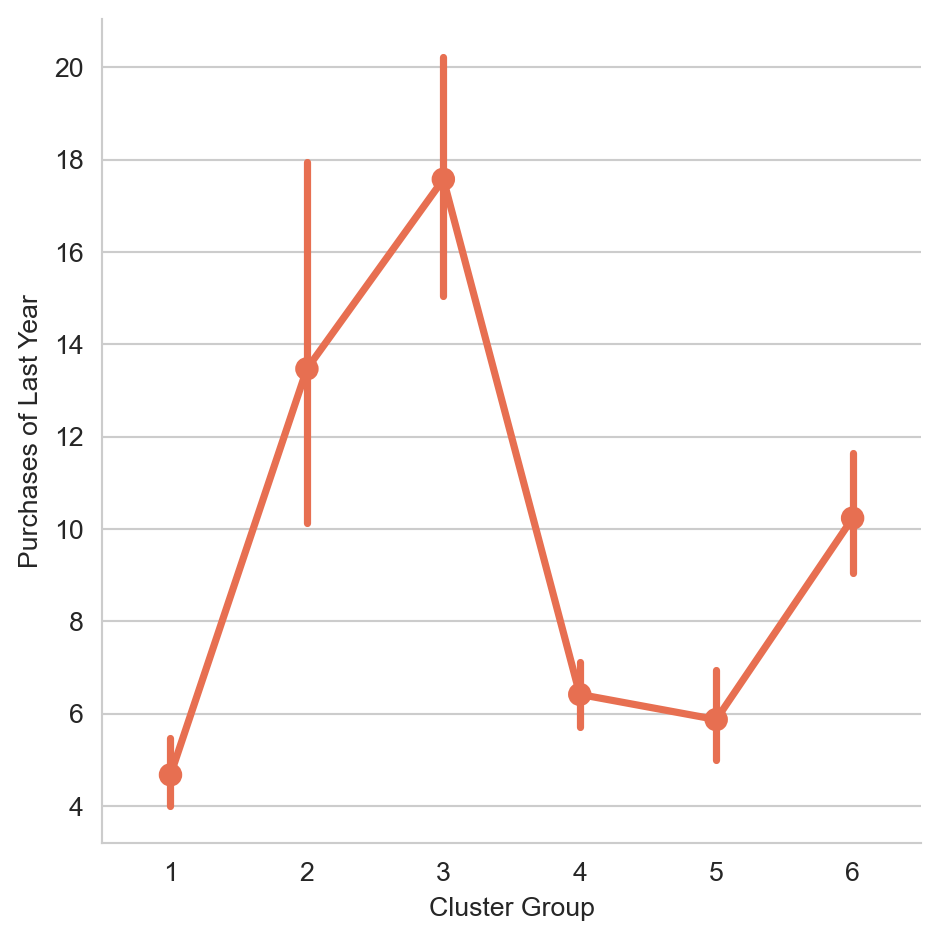

<Figure size 672x480 with 0 Axes>

In [58]:
sns.catplot(x = 'Cluster Group', y = 'last_purchases', kind = 'point', data = merged_data, color = plot_colors[4])
plt.ylabel('Purchases of Last Year')
plt.show()
plt.clf()

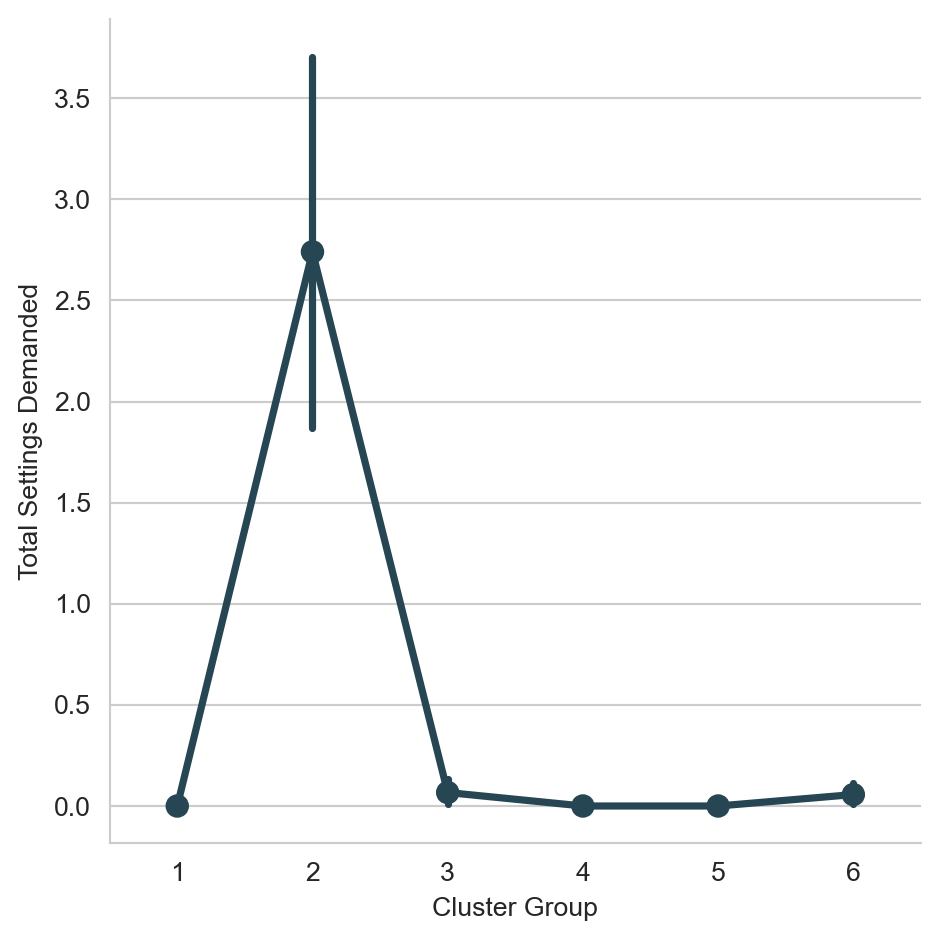

<Figure size 672x480 with 0 Axes>

In [59]:
sns.catplot(x = 'Cluster Group', y = 'total_settings', kind = 'point', data = merged_data, color = plot_colors[0])
plt.ylabel('Total Settings Demanded')
plt.show()
plt.clf()

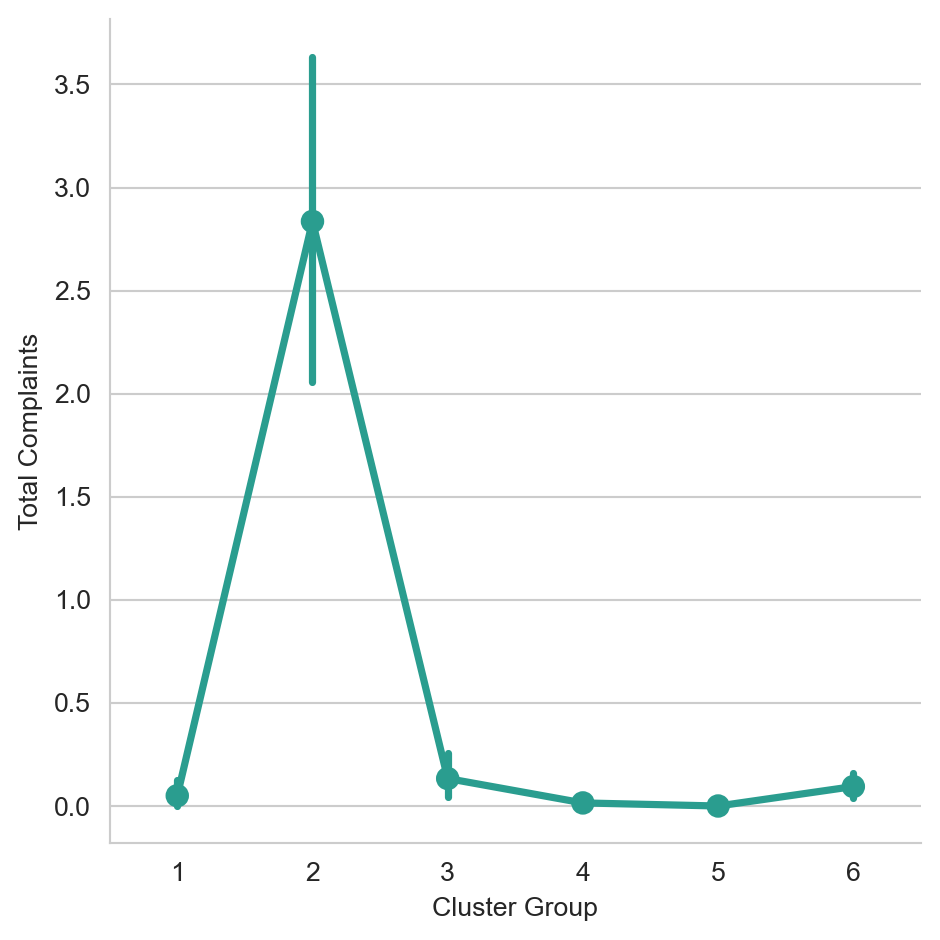

<Figure size 672x480 with 0 Axes>

In [60]:
sns.catplot(x = 'Cluster Group', y = 'total_complaints', kind = 'point', data = merged_data, color = plot_colors[1])
plt.ylabel('Total Complaints')
plt.show()
plt.clf()

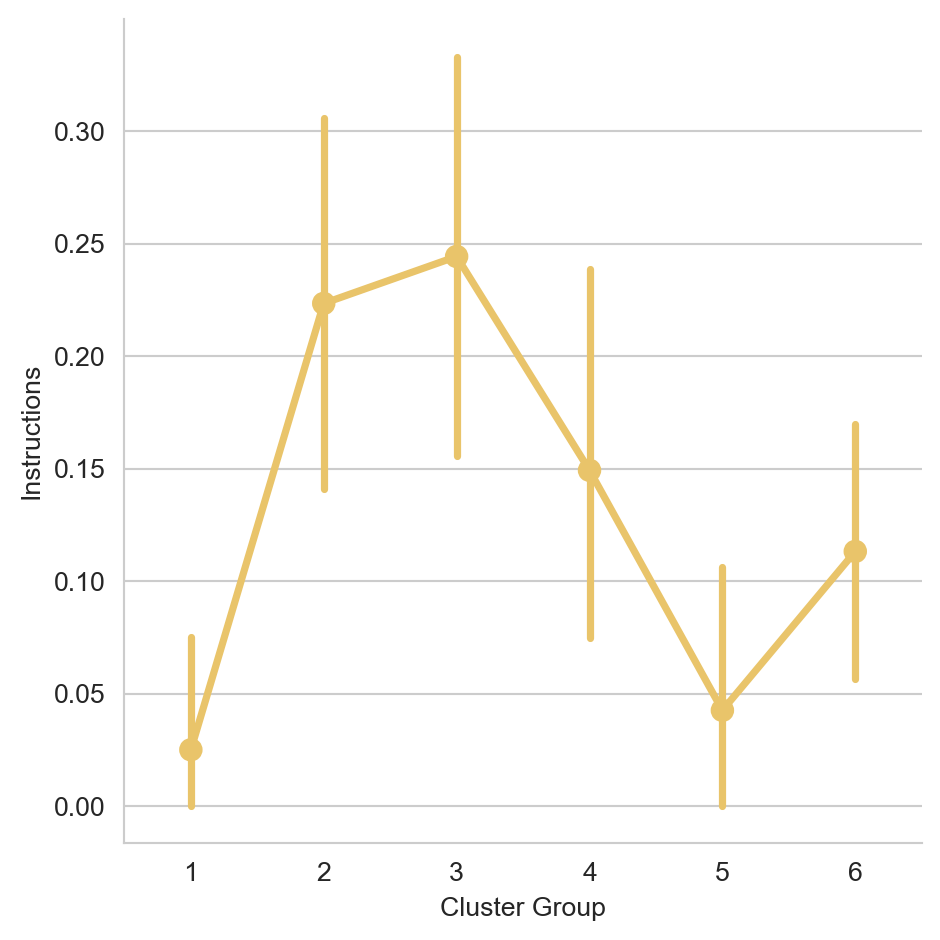

<Figure size 672x480 with 0 Axes>

In [61]:
sns.catplot(x = 'Cluster Group', y = 'Instructions', kind = 'point', data = merged_data, color = plot_colors[2])
plt.ylabel('Instructions')
plt.show()
plt.clf()

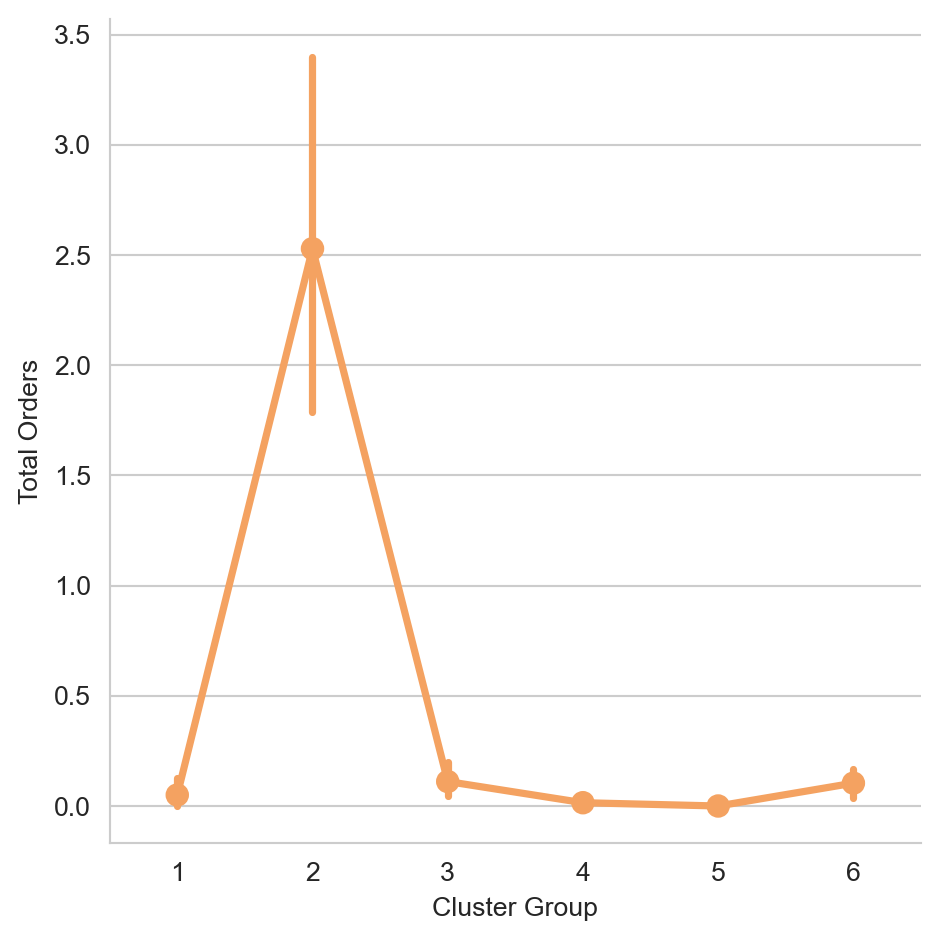

<Figure size 672x480 with 0 Axes>

In [62]:
sns.catplot(x = 'Cluster Group', y = 'total_orders', kind = 'point', data = merged_data, color = plot_colors[3])
plt.ylabel('Total Orders')
plt.show()
plt.clf()